# Visualising Results
## Overview
Here we visualise many of the outputs from the SNP- and SV-based population analyses for fairy tern (*Sterna nereis*) populations in Western Australian (*S. n. nereis*) and Aotearoa New Zealand (*S. n. davisae*) as well as the critically endangered kakī (*Himantopus novaezelandiae*). We examine the number proportion, and density of Runs of Homozygosity (ROHs) to compare relative levels of inbreeding (*fROH*). We then leverage these estimates of *F<sub>ROH</sub>* to infer recent demographic trends, and compare with pedigree-based estimates of inbreeding for kakī.  

We then explore population structure among fairy tern populations by visualising genome-wide F<sub>ST</sub>, and a multidimensional scaling (MDS) analysis generated by NGStools and examine the folded and unfolded site frequency spectrum (SFS) for each of the three taxa. Finally, we compare with estimates of putative masked and realised load in the tara iti and kakī populations.  

In our first step, we import the necessary python packages.  

In [39]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#path = r"C:\Users\Jana\Git_Repos\2024_MolEcol_ConsGen_Special_Issue"
path = 'G:\My Drive\Data\S_nereis_ssp\genomic_data'
os.chdir(path)
print(os.getcwd())

G:\My Drive\Data\S_nereis_ssp\genomic_data


## Population Diversity
### Runs of Homozygosity (ROHs)
We first examined the number of short (>50kb & <=200kb in length), medium (>200kb & <=700kb in length) and long (>700kb in length) ROHs per individual. This is to provide some indication of long-, medium- and short-term inbreeding levels respectively for each of the populations. Here, we can see that tara iti consistently have more ROHs across all three size classes.  

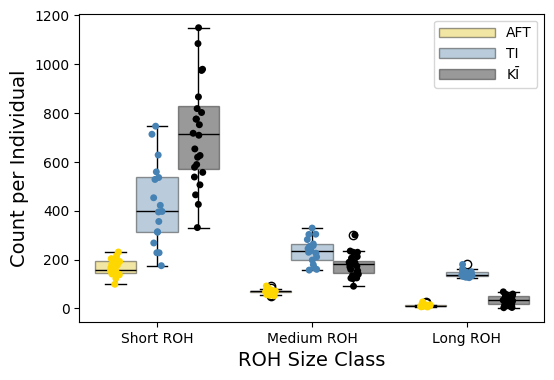

In [17]:
roh = pd.read_csv('ROHAN_out\ROHs.tsv', delimiter='\t')
roh = roh[(roh['Sample']!='SP01') & roh['Sample']!='TI22']

roh_summary = roh[['Sample', 'ROH_class', 'Population']]
roh_summary = roh_summary.groupby(['Sample', 'ROH_class', 'Population']).size().reset_index(name='ROH Counts')
roh_summary = roh_summary.sort_values('ROH_class', ascending=False)

xvalues = ["Short ROHs", "Medium ROHs", "Long ROHs"]
palette = ['gold', 'steelblue', 'black']

plt.figure(figsize=(6,4))
ax = sns.boxplot(data=roh_summary, x="ROH_class", y="ROH Counts",
                 hue="Population", palette=palette, hue_order=['AU', 'TI', 'KI'], boxprops={'alpha': 0.4})
sns.stripplot(data=roh_summary, x="ROH_class", y="ROH Counts",
              hue="Population", palette=palette, hue_order=['AU', 'TI', 'KI'], dodge=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles,
          labels=['AFT', 'TI', 'KĪ'],
          loc='upper right', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})
ax.set_xlabel('ROH Size Class', fontsize=14)
ax.set_ylabel("Count per Individual", fontsize=14)

plt.savefig('plots/ROH_counts.png', dpi=300, bbox_inches='tight')

We also examined the proportion of the genome impacted by ROHs for each individual of Australian fairy tern and tara iti. The higher count of ROHs in tara iti population also translated to a higher proportion of the genome impacted overall. However, the vast majority of ROHs impacting the genome is attributable to those in the 'large' (>700kb in length) category. This indicates that the tara iti population has remained chronically small for several generations.  

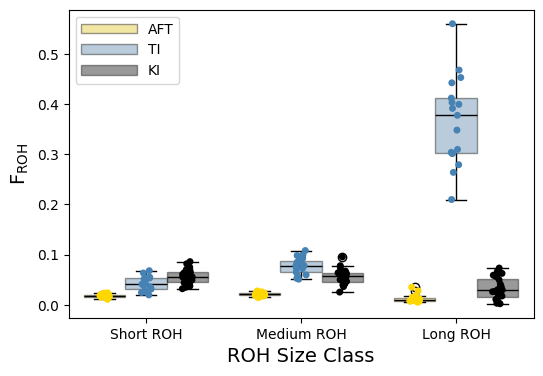

In [40]:
roh = pd.read_csv('ROHAN_out/ROHs.tsv', sep='\t')
roh = roh[(roh['Sample']!='SP01') & roh['Sample']!='TI22']

roh_len = roh[['Sample', 'ROH_size', 'ROH_class', 'Population']]
roh_len = roh_len.groupby(['Sample', 'ROH_class', 'Population'])['ROH_size'].sum().reset_index(name='ROH Total')
roh_len['Proportion'] = (roh_len['ROH Total'] / 1200000000)
roh_len = roh_len.sort_values('ROH_class', ascending=False)

palette = ['gold', 'steelblue', 'black']

plt.figure(figsize=(6,4))
ax = sns.boxplot(data=roh_len, x="ROH_class", y="Proportion",
                 hue="Population", palette=palette, hue_order=['AU', 'TI', 'KI'], boxprops={'alpha': 0.4})
sns.stripplot(data=roh_len, x="ROH_class", y="Proportion",
              hue="Population", palette=palette, hue_order=['AU', 'TI', 'KI'], dodge=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles,
          labels=['AFT', 'TI', 'KI'],
          loc='upper left', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})

params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
ax.set_xlabel('ROH Size Class', fontsize=14)
ax.set_ylabel("$F_{ROH}$", fontsize=14)

plt.savefig('plots/ROH_genome_proportions.png', dpi=300, bbox_inches='tight')

We then examined the density of Runs of Homozygosity (ROHs) by size class. Here, we plot ROHs presence at a particular location across individuals for chromosome 1 as a means to visualise relative *fROH* among individuals.  

To start, we load and subset the original `ROH_density.tsv` file by population, ROH size class, and position (`BEGIN` and `END`).  

We then define a plot function that marks the presence/absence of ROHs by their `BEGIN` and `END` position along chromosome 1. The color `seagreen` denotes ROHs smaller than or equal to 200kb in length, `wheat` indicates ROHs larger than 200kb and smaller than or equal to 700kb, and `coral` represents ROHs larger than 700kb.  

In [4]:
def plot_rohs(df, chromosome, individuals, continuous_range, alpha_multiplier=1, color_mapping=None, figsize=(20, 15)):
    """
    Plot ROH presence along the chromosome for specific individuals.

    Parameters:
        df (DataFrame): Input DataFrame containing 'Chromosome', 'BEGIN', 'END', 'ROH_class', and 'Individual' columns.
        chromosome (str): Chromosome to plot.
        individuals (list): List of individuals to include in the plot.
        continuous_range (range or list): Continuous range of positions to consider.
        alpha_multiplier (float): Multiplier to adjust alpha based on the number of overlapping ranges.
        color_mapping (dict): Mapping of ROH classes to colors.
        figsize (tuple, optional): Size of the figure in inches (width, height).

    Returns:
        None
    """
    num_individuals = len(individuals)
    fig, axs = plt.subplots(num_individuals, 1, figsize=figsize, sharex=True, sharey=True)

    for i, individual in enumerate(individuals):
        ax = axs[i]
        # Filter Pandas DataFrame for the specified chromosome and individual
        chrom_ind_df = df[(df['Chromosome'] == chromosome) & (df['Sample'] == individual)]
        
        # Get color for ROH class
        if color_mapping:
            chrom_ind_df['Color'] = chrom_ind_df['ROH_class'].map(color_mapping)
        else:
            chrom_ind_df['Color'] = 'steelblue'  # Default color

        # Plot ROH presence
        for _, row in chrom_ind_df.iterrows():
            start, end = row['BEGIN'], row['END']
            ax.fill_between(range(start, end+1), 0, 1, color=row['Color'], alpha=alpha_multiplier, edgecolor=None)
        
        # Set plot title and labels
        ax.set_ylabel('ROH Presence')

        # Remove y-axis ticks
        ax.set_yticks([])

        # Set x-axis limits
        ax.set_xlim(min(continuous_range), max(continuous_range))

    axs[-1].set_xlabel('Position on Chromosome', fontsize = 12)

    plt.tight_layout()

# Define Color mapping
color_mapping = {
    'Short ROH': 'seagreen',
    'Medium ROH': 'wheat',
    'Long ROH': 'coral'
}
# Define chromosome size
chr1_size = range(0, 219000000, 1000)

Australian fairy tern with the smallest *F<sub>ROH</sub>*: AU13 (4.53%)
Australian fairy tern with median *F<sub>ROH</sub>*: AU08 (5.59%)
Australian fairy tern with the largest *F<sub>ROH</sub>*: AU03 (9.01%)

C:\Users\Jana\AppData\Local\Temp\ipykernel_13364\1012803755.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chrom_ind_df['Color'] = chrom_ind_df['ROH_class'].map(color_mapping)
C:\Users\Jana\AppData\Local\Temp\ipykernel_13364\1012803755.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chrom_ind_df['Color'] = chrom_ind_df['ROH_class'].map(color_mapping)
C:\Users\Jana\AppData\Local\Temp\ipykernel_13364\1012803755.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

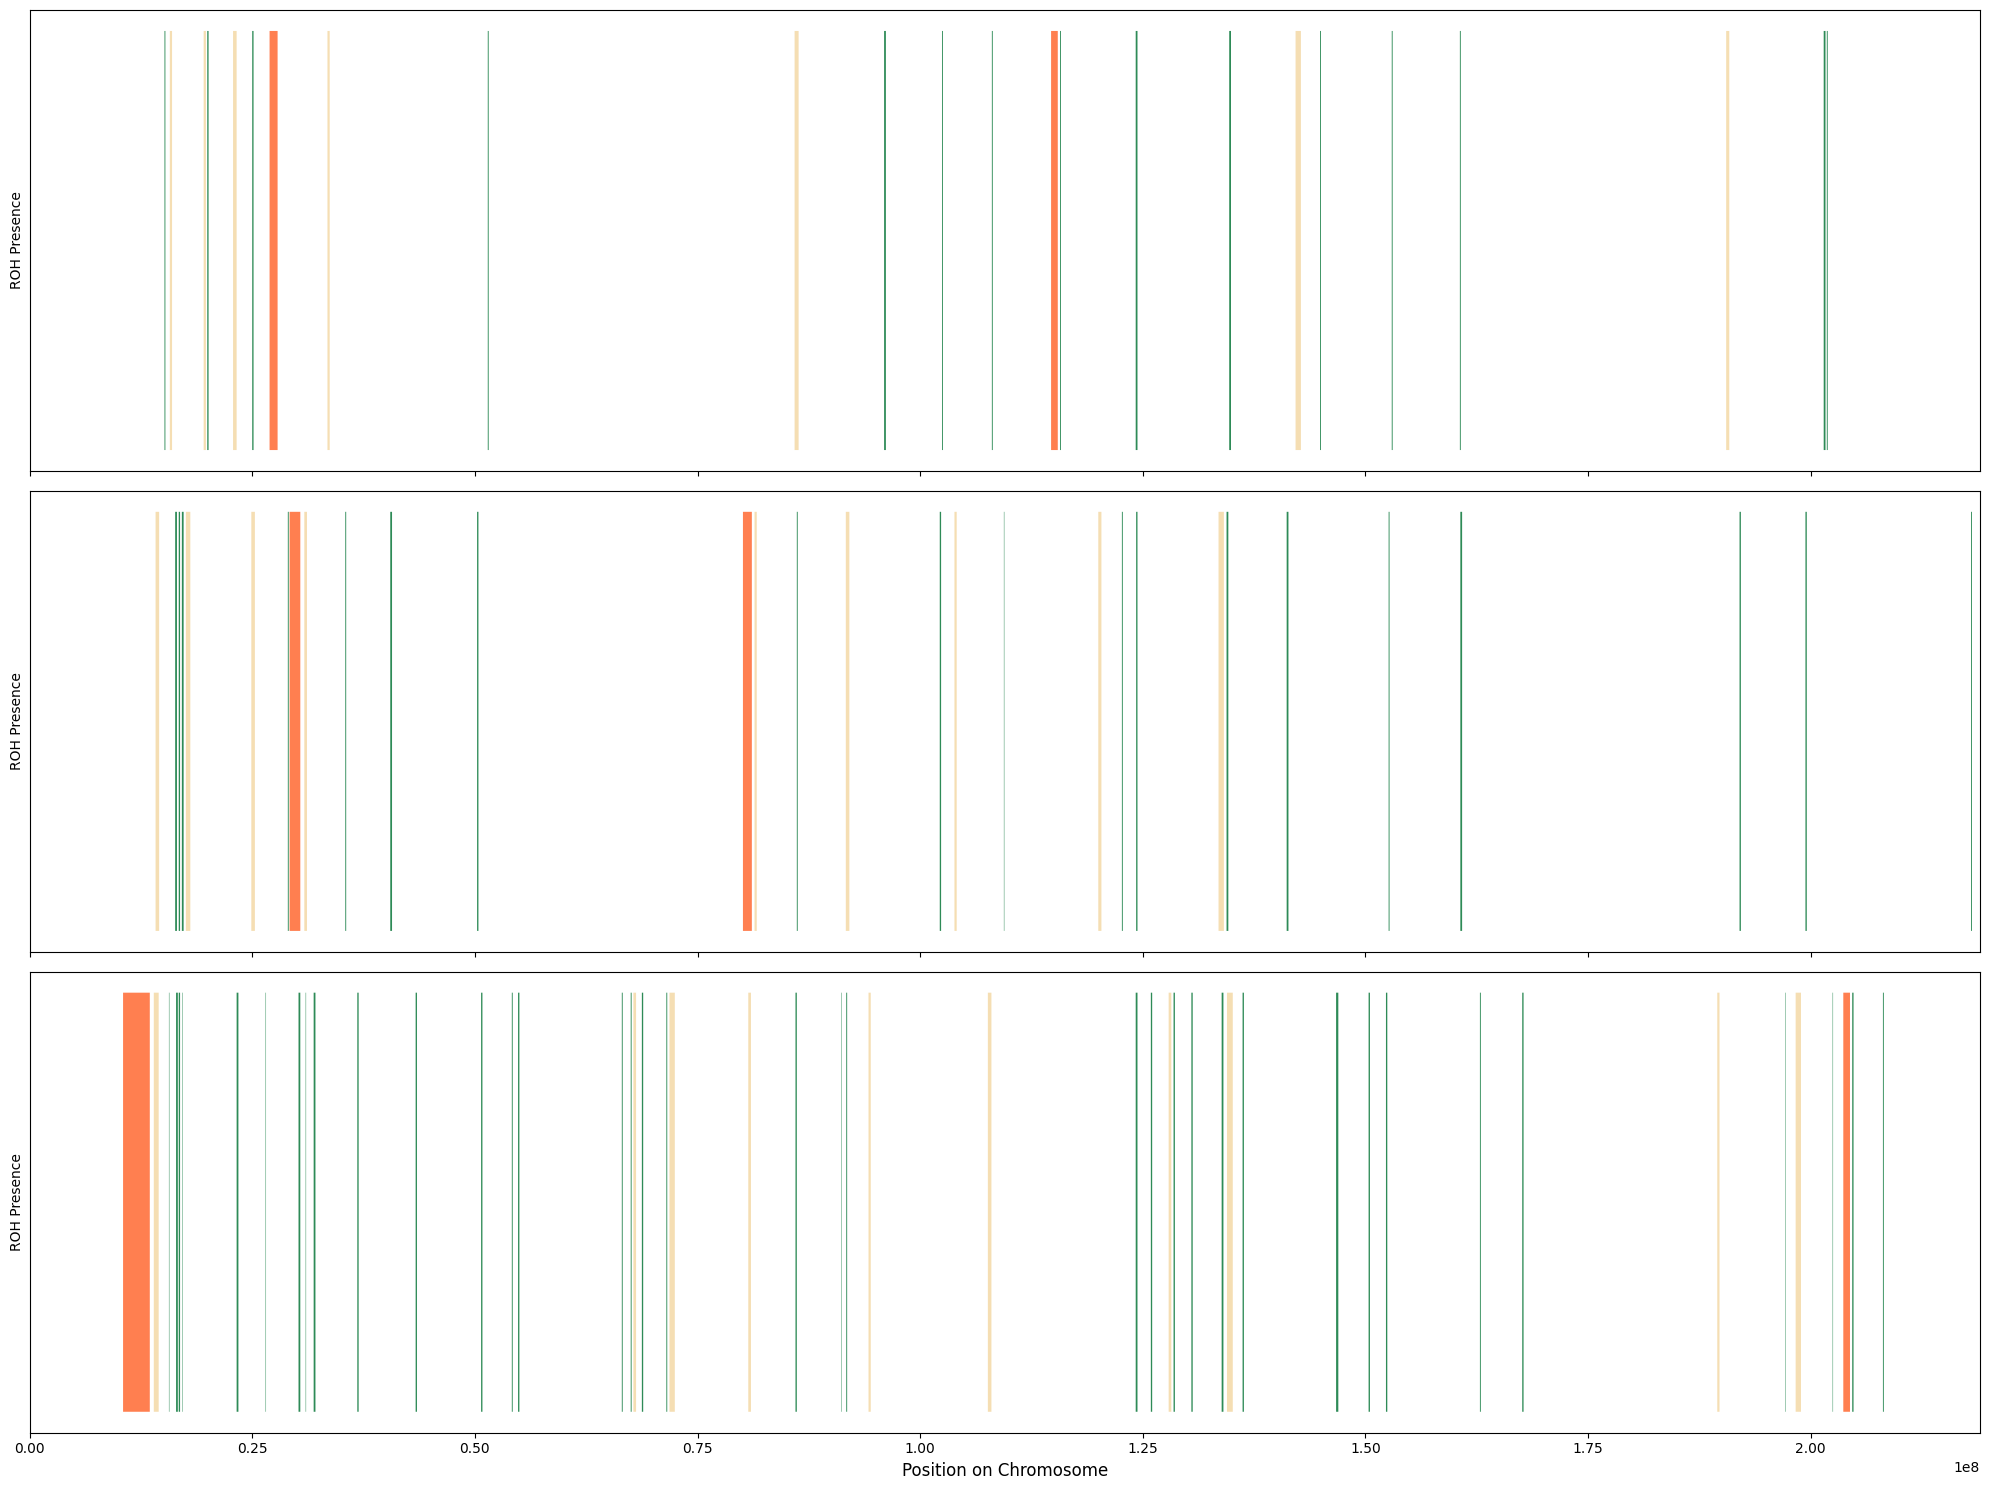

In [18]:
chrom = 'CM020437.1_RagTag'
individuals = ['AU13', 'AU08', 'AU03']

plot_rohs(roh, chrom, individuals, chr1_size, color_mapping=color_mapping)
plt.savefig('plots/AU_ROH_positions.png', dpi=300, bbox_inches='tight')

Tara iti with the smallest *F<sub>ROH</sub>*: TI21 (47.54%)
Tara iti with median *F<sub>ROH</sub>*: TI40 (60.17%)
Tara iti with the largest *F<sub>ROH</sub>*: SND05 (77.74%)

C:\Users\Jana\AppData\Local\Temp\ipykernel_13364\1012803755.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chrom_ind_df['Color'] = chrom_ind_df['ROH_class'].map(color_mapping)
C:\Users\Jana\AppData\Local\Temp\ipykernel_13364\1012803755.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chrom_ind_df['Color'] = chrom_ind_df['ROH_class'].map(color_mapping)
C:\Users\Jana\AppData\Local\Temp\ipykernel_13364\1012803755.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

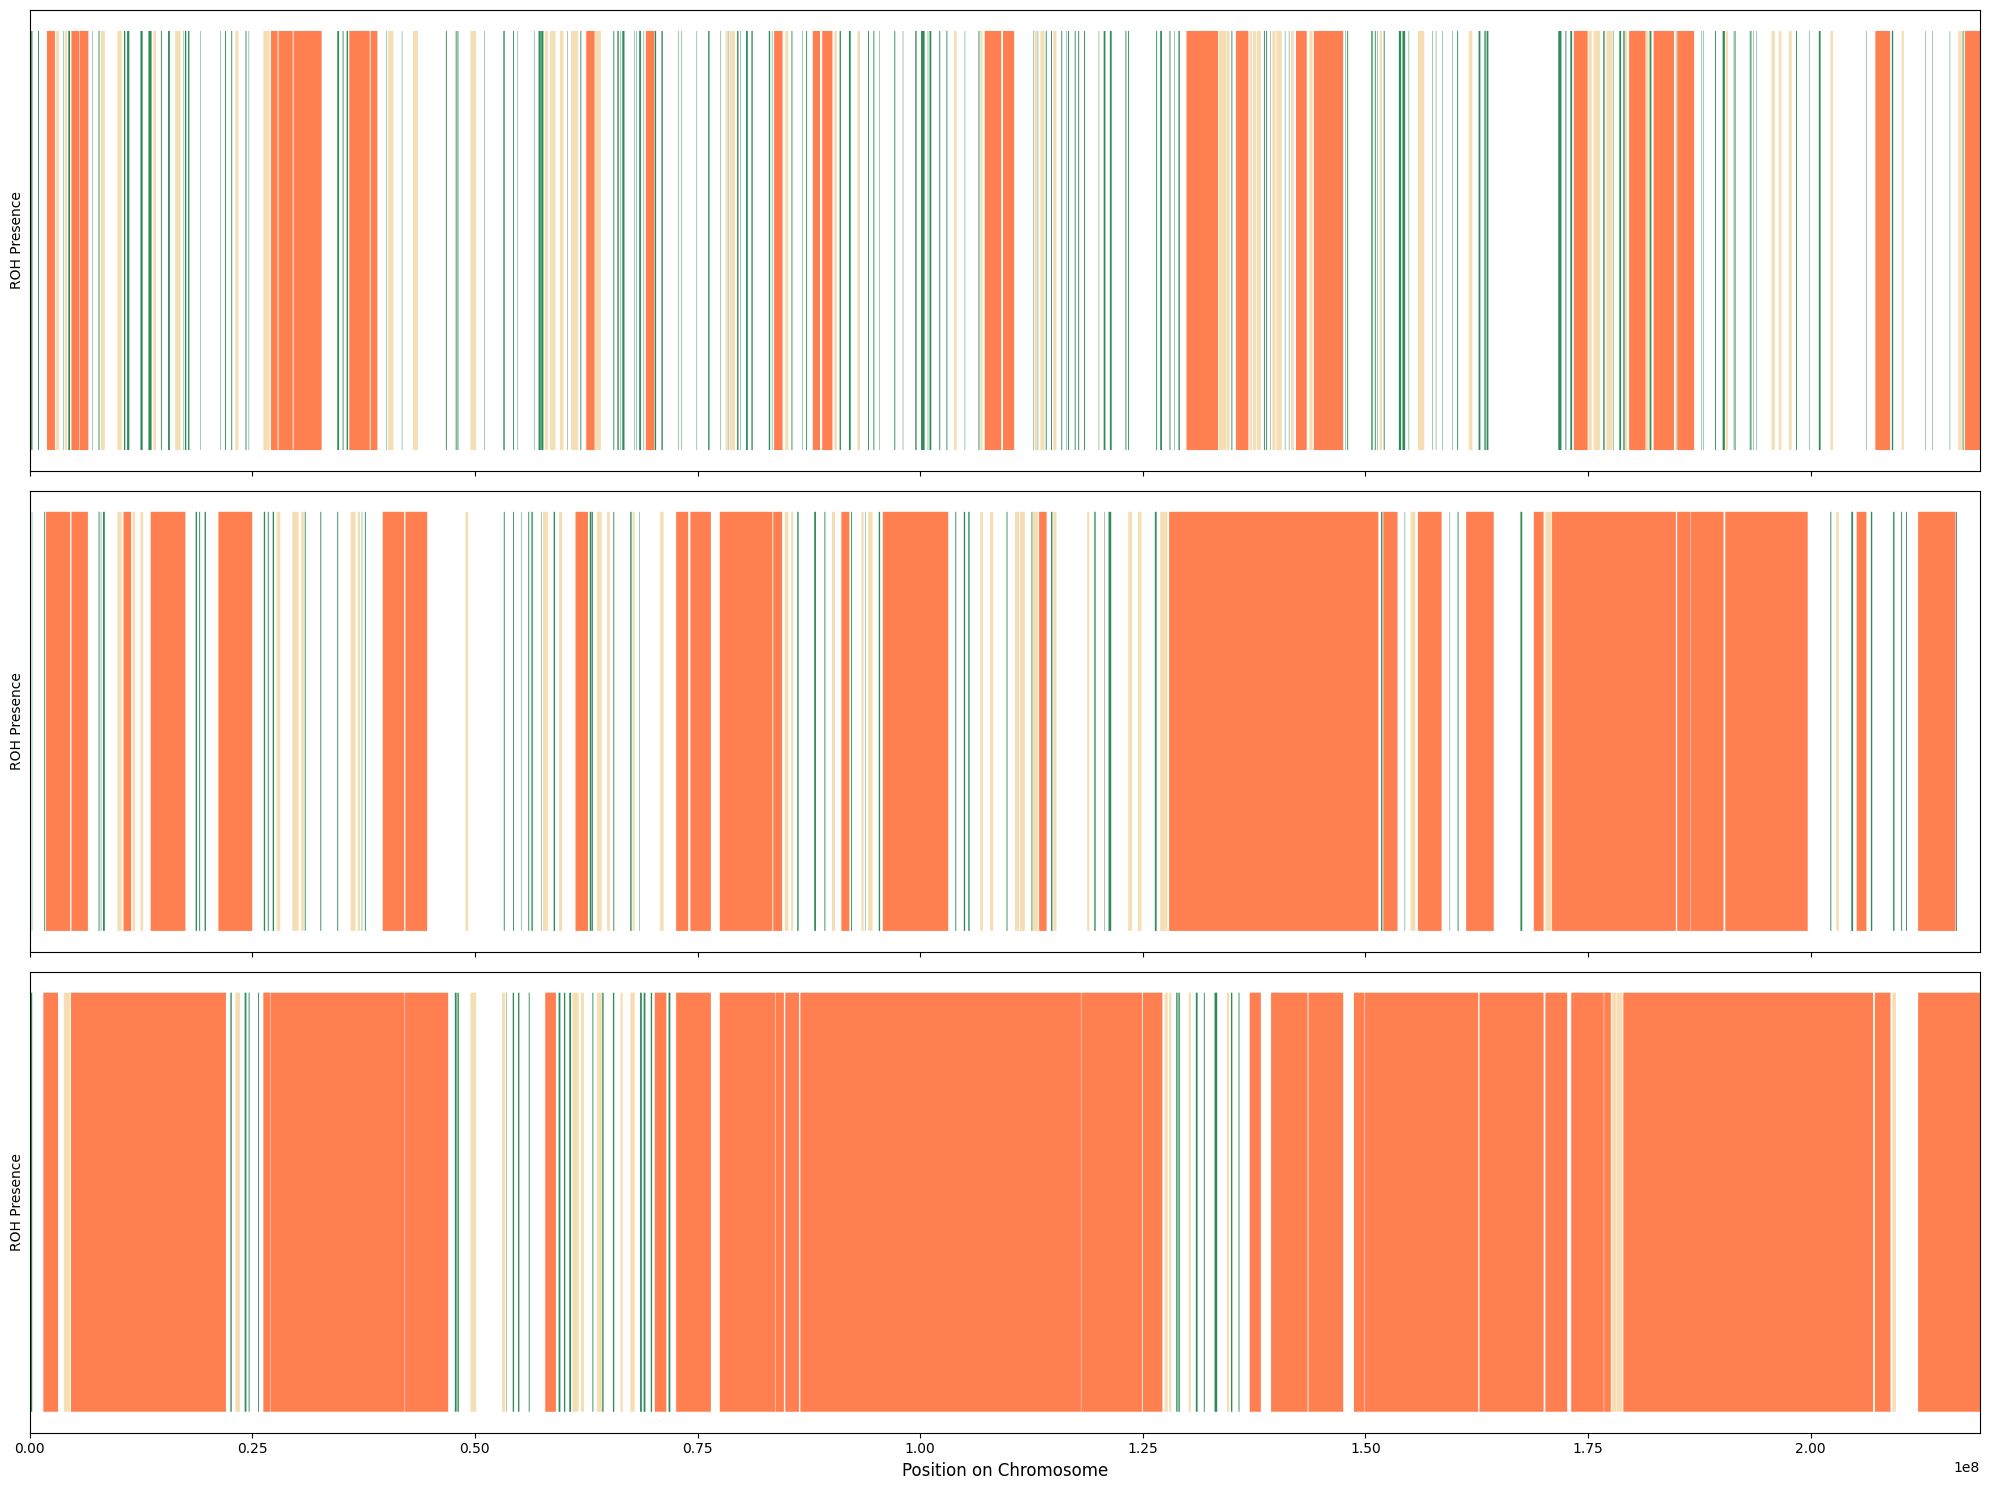

In [19]:
chrom = 'CM020437.1_RagTag'
individuals = ['TI21', 'TI40', 'SND05']

plot_rohs(roh, chrom, individuals, chr1_size, color_mapping=color_mapping)
plt.savefig('plots/TI_ROH_positions.png', dpi=300, bbox_inches='tight')

Kakī with the smallest *F<sub>ROH</sub>*: H01396 (7.76%)
Kakī with median *F<sub>ROH</sub>*: H01385 (17.04%)
Kakī with the largest *F<sub>ROH</sub>*: H01390 (25.88%)

C:\Users\Jana\AppData\Local\Temp\ipykernel_2992\1012803755.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chrom_ind_df['Color'] = chrom_ind_df['ROH_class'].map(color_mapping)
C:\Users\Jana\AppData\Local\Temp\ipykernel_2992\1012803755.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chrom_ind_df['Color'] = chrom_ind_df['ROH_class'].map(color_mapping)
C:\Users\Jana\AppData\Local\Temp\ipykernel_2992\1012803755.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

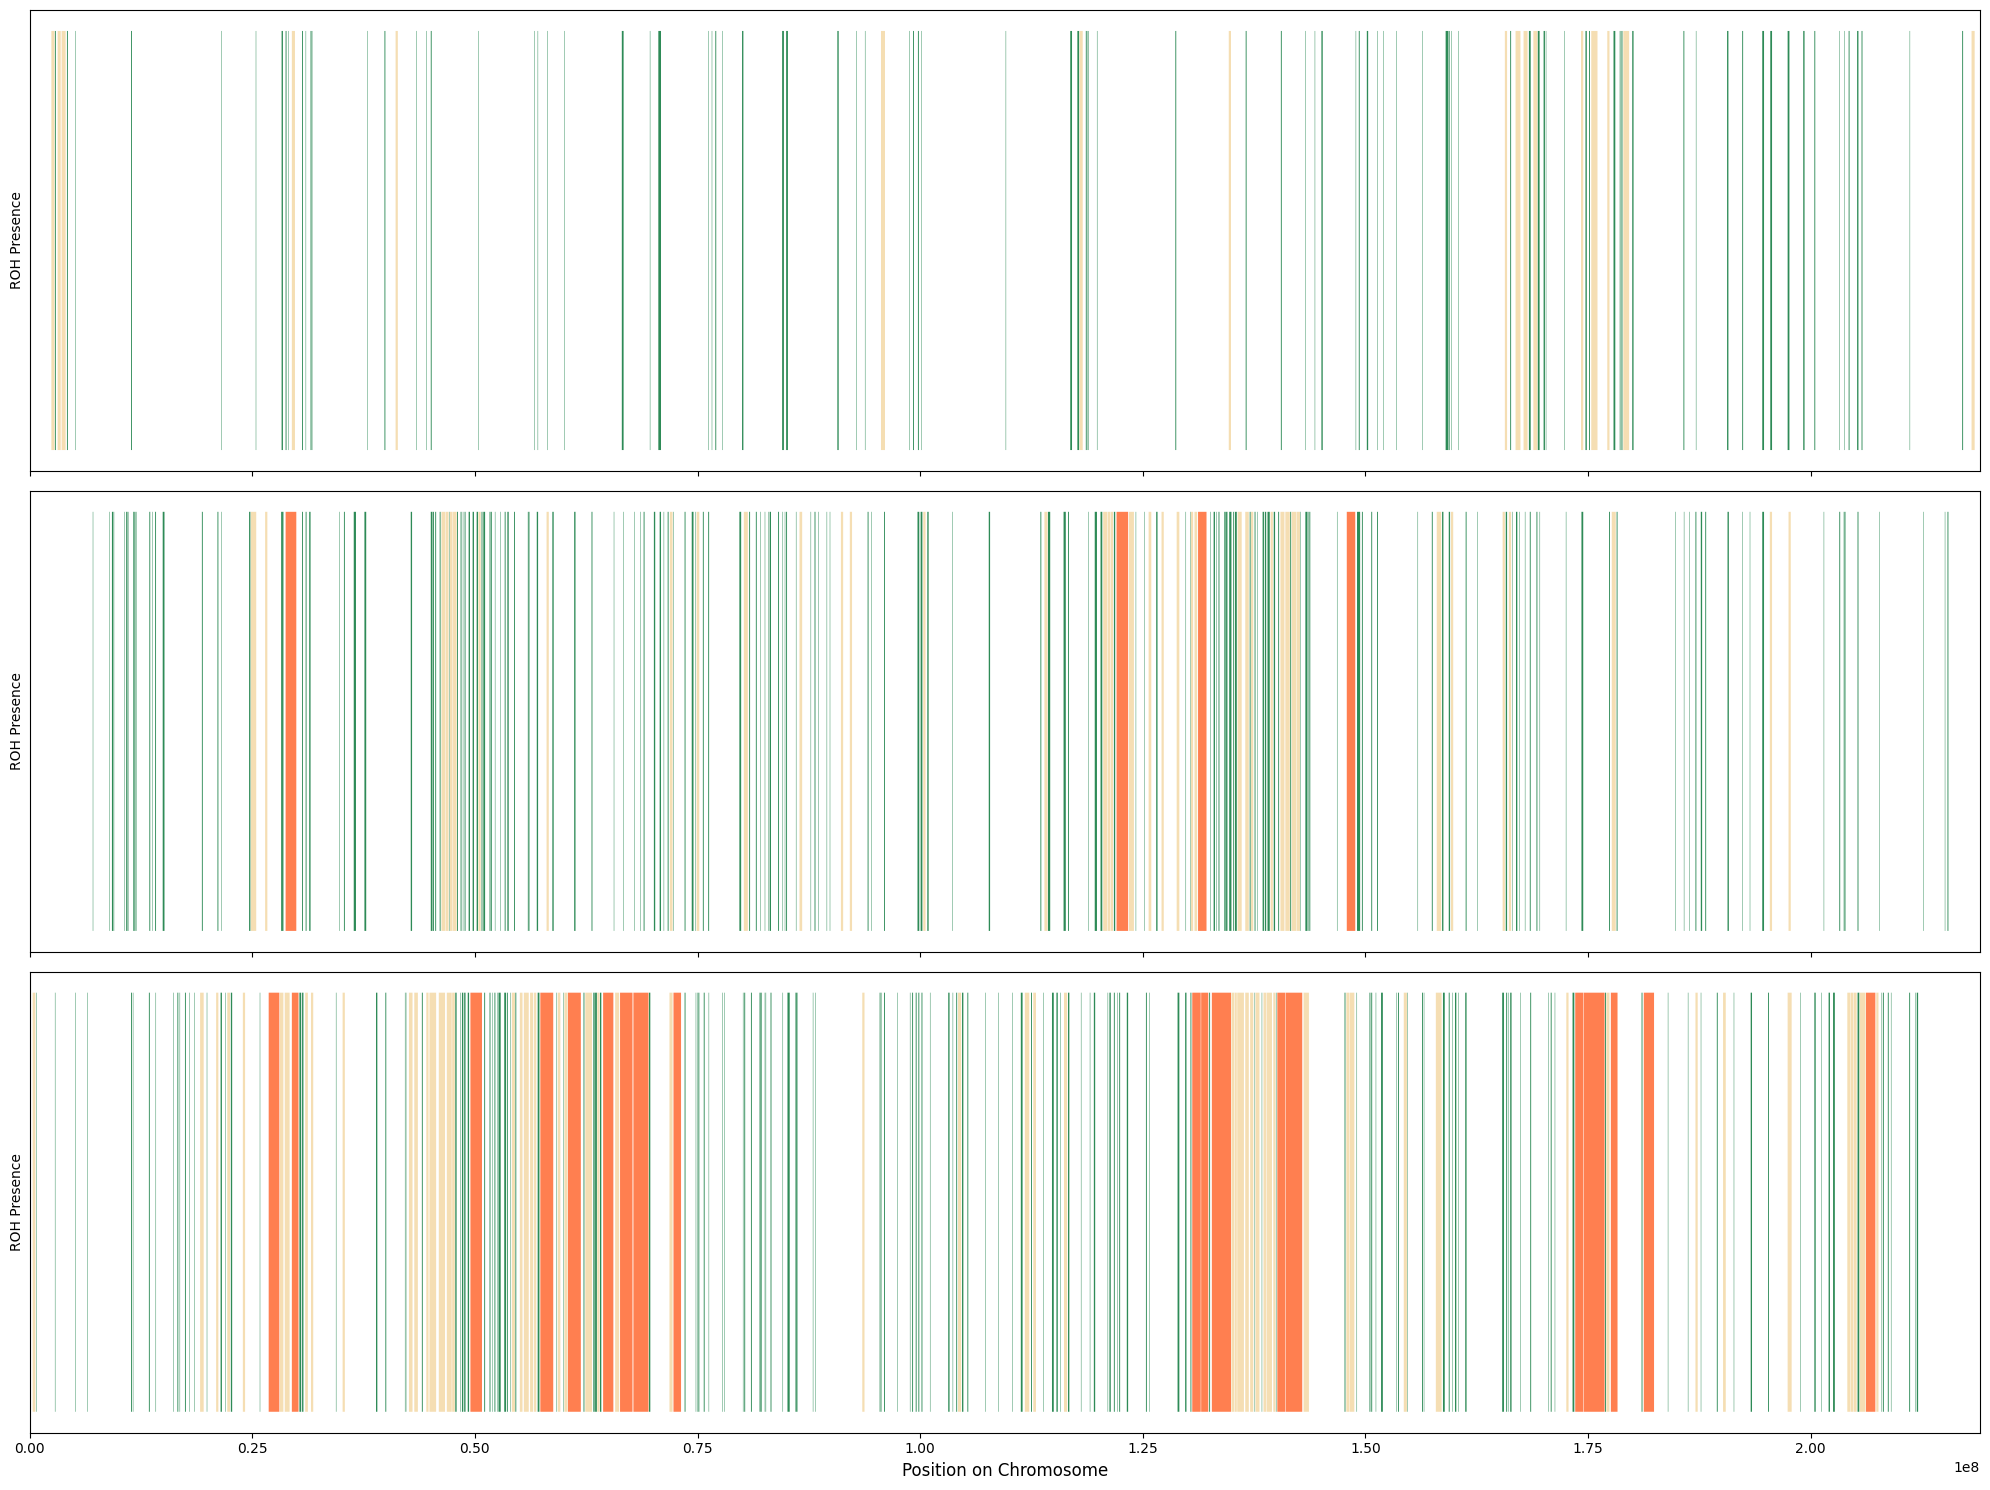

In [8]:
chrom = 'scaffold_1'
individuals = ['H01396', 'H01385', 'H01390']

plot_rohs(roh, chrom, individuals, chr1_size, color_mapping=color_mapping)
plt.savefig('plots/KI_ROH_positions.png', dpi=300, bbox_inches='tight')

### Observed Heterozygosity (*H<sub>O</sub>*)
#### SNP-based *H<sub>O</sub>* Estimates
The next diversity metric we examined was individual observed heterozygosity as estimated by `ANGSD` and `realSFS` for all sites. 

C:\Users\Jana\AppData\Local\Temp\ipykernel_13364\887021054.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['AFT', 'TI', 'KĪ'])


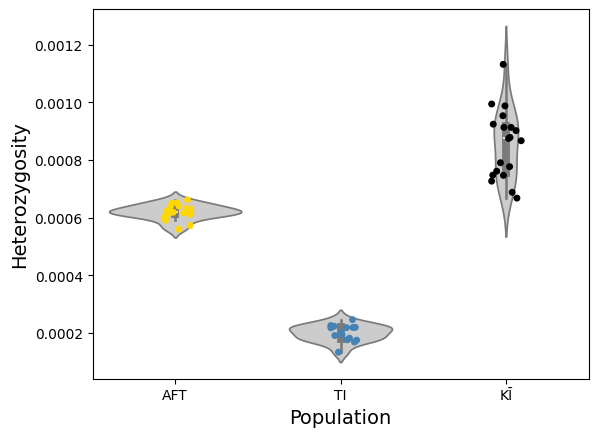

In [21]:
palette = ['gold', 'steelblue', 'black']
indiv_het = pd.read_csv('angsd/individual_het.tsv', delimiter='\t')
indiv_het = indiv_het.sort_values(by=['Sample', 'Population'], ascending=[True, True])

wholegenome_het = indiv_het[indiv_het["Tool"] == 'whole-genome_folded']

ax = sns.violinplot(data = wholegenome_het, x = "Population", y = "Heterozygosity", order=['AU', 'TI', 'KI'], color="0.8")
sns.stripplot(data = wholegenome_het, x = "Population", y = "Heterozygosity",
                   hue = "Population", hue_order=['AU', 'TI', 'KI'], palette=palette, jitter = True)
handles, labels = ax.get_legend_handles_labels()

ax.set_xticklabels(['AFT', 'TI', 'KĪ'])
ax.set_xlabel('Population', fontsize=14)
ax.set_ylabel("Heterozygosity", fontsize=14)

plt.savefig('plots/indiv_het_wholeGenome.png', dpi=300, bbox_inches='tight')

And for putatively 'neutral' sites where we excluded regions predicted to be coding regions by `AUGUSTUS`.  

C:\Users\Jana\AppData\Local\Temp\ipykernel_13364\1457548872.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['AFT', 'TI', 'KĪ'])


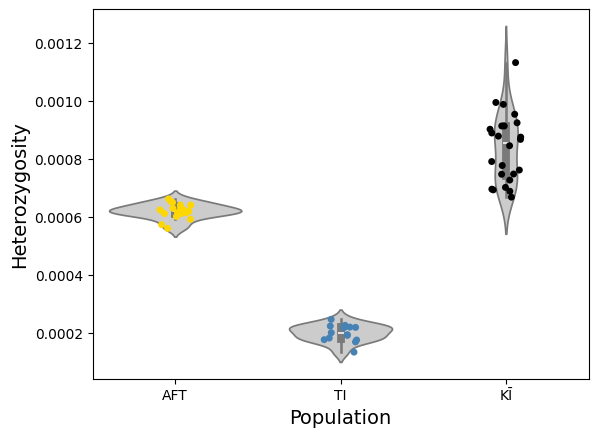

<Figure size 1800x700 with 0 Axes>

In [22]:
neutral_het = indiv_het[indiv_het['Tool'] == 'neutral_folded']

ax = sns.violinplot(data = neutral_het, x = "Population", y = "Heterozygosity", order=['AU', 'TI', 'KI'], color="0.8")
sns.stripplot(data = neutral_het, x = "Population", y = "Heterozygosity",
                   hue = "Population", hue_order=['AU', 'TI', 'KI'], palette=palette, jitter = True)
handles, labels = ax.get_legend_handles_labels()

ax.set_xticklabels(['AFT', 'TI', 'KĪ'])
ax.set_xlabel('Population', fontsize=14)
ax.set_ylabel("Heterozygosity", fontsize=14)

plt.figure(figsize=(18,7))

plt.savefig('plots/indiv_het_neutralSites.png', dpi=300, bbox_inches='tight')

#### SV-based *H<sub>O</sub>* Estimates
We estimated structural variant heterozygosity as:
$$
H_{O} = \frac{\sum{H Sites}}{\sum{Genotyped Sites}}
$$

C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\1011119143.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['AFT', 'TI', 'KĪ'])


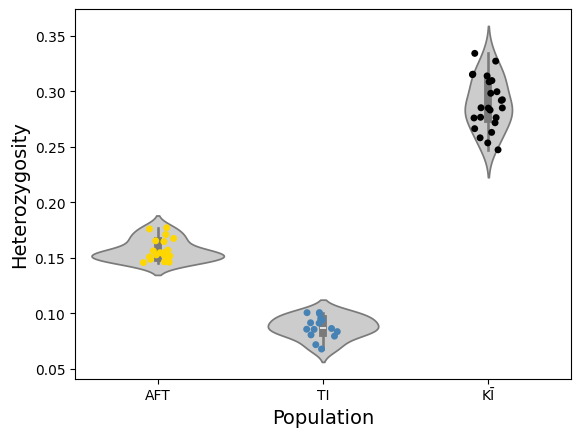

In [2]:
palette = ['gold', 'steelblue', 'black']

sv_het = pd.read_csv('graphtyper/individual_svHet.tsv', delimiter='\t')

ax = sns.violinplot(data = sv_het, x = 'Population', y = 'SV Heterozygosity', color='0.8')
sns.stripplot(data = sv_het, x = 'Population', y = 'SV Heterozygosity',
              hue = 'Population', palette=palette, jitter = True)
handles, labels = ax.get_legend_handles_labels()

ax.set_xticklabels(['AFT', 'TI', 'KĪ'])
ax.set_xlabel('Population', fontsize=14)
ax.set_ylabel('Heterozygosity', fontsize=14)

plt.savefig('plots/indiv_het_SVs.png', dpi=300, bbox_inches='tight')

### *F<sub>ROH</sub>* Relationship with H<sub>o</sub>
#### SNPs

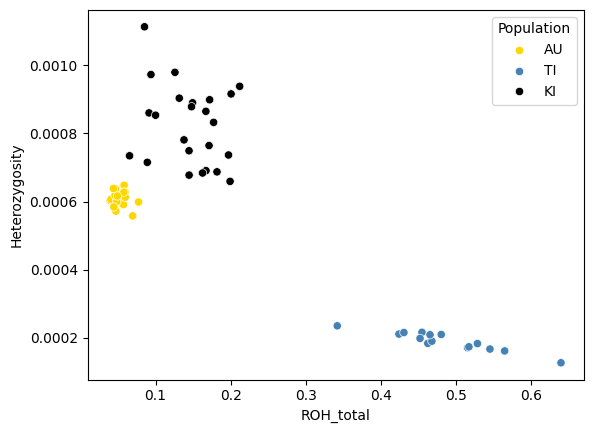

In [43]:
palette = ['gold', 'steelblue', 'black']

het = pd.read_csv('angsd/individual_het.tsv', delimiter='\t')
het = het[het['Tool'] == 'neutral']
het = het[['Sample', 'Population', 'Heterozygosity']]

div = roh_len[["Sample", "Population", "Proportion"]]
div = div.groupby(['Sample', 'Population'])['Proportion'].sum().reset_index(name='ROH_total')
div = div[(div['Sample'] != 'SP01') & (div['Sample'] != 'TI22')]

# Merge data
diversity = pd.merge(het, div, on=['Sample', 'Population'])

# Plot
palette = ['gold', 'steelblue', 'black']
ax = sns.scatterplot(data=diversity, x="ROH_total", y="Heterozygosity",
                     hue="Population", palette=palette, hue_order=['AU', 'TI', 'KI'])

# Set legend labels
ax.legend(title='Population', loc='upper right')

# Save the plot
plt.savefig('plots/roh_SNPhet_relationship.png', dpi=300, bbox_inches='tight')

#### Structural Variants

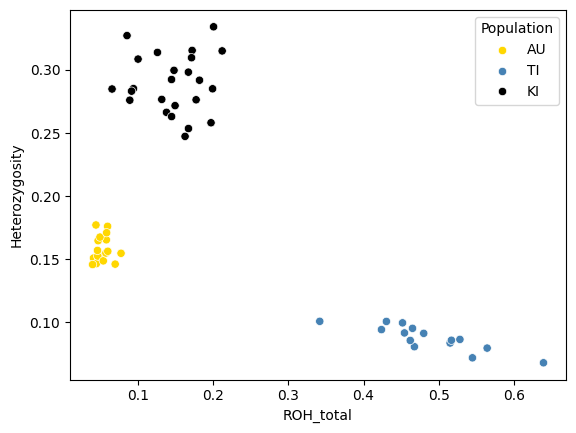

In [42]:
palette = ['gold', 'steelblue', 'black']

sv_het = pd.read_csv('graphtyper/individual_svHet.tsv', delimiter='\t')
sv_het['Heterozygosity'] = sv_het['SV Heterozygosity']

div = roh_len[["Sample", "Population", "Proportion"]]
div = div.groupby(['Sample', 'Population'])['Proportion'].sum().reset_index(name='ROH_total')
div = div[(div['Sample'] != 'SP01') & (div['Sample'] != 'TI22')]

# Merge data
diversity = pd.merge(sv_het, div, on=['Sample', 'Population'])

# Plot
palette = ['gold', 'steelblue', 'black']
ax = sns.scatterplot(data=diversity, x="ROH_total", y="Heterozygosity",
                     hue="Population", palette=palette, hue_order=['AU', 'TI', 'KI'])

# Set legend labels
ax.legend(title='Population', loc='upper right')

# Save the plot
plt.savefig('plots/roh_SVhet_relationship.png', dpi=300, bbox_inches='tight')

### Nucleotide diversity (π) 
Below we plot nucleotide diversity for both putatively neutral and all sites.  

In [ ]:
cols=["Chr", "WinCenter", "tW", "tP", "tF", "tH", "tL", "Tajima", "fuf", "fud", "fayh", "zeng", "nSites"]
au_neutral = pd.read_csv('angsd/diversity/AU_pest_neutral_thetas_50KBwindows_10kbStep.pestPG', sep='\t', usecols=cols)
ti_neutral = pd.read_csv('angsd/diversity/TI_pest_neutral_thetas_50KBwindows_10KBstep.pestPG', sep='\t', usecols=cols)

au_neutralpi = au_neutral[['Chr', 'WinCenter', 'tP', 'nSites']]
ti_neutralpi = ti_neutral[['Chr', 'WinCenter', 'tP', 'nSites']]

au_neutralpi['Nucleotide Diversity'] = (au_neutralpi['tP'] / au_neutralpi['nSites'])
ti_neutralpi['Nucleotide Diversity'] = (ti_neutralpi["tP"] / ti_neutralpi["nSites"])
#print("The total nucleotide diverity for Australian fairy tern is", au_neutralpi['AU Nucleotide Diversity'].mean(), "While nucleotide diversity for tara iti is", ti_neutralpi['NZ Nucleotide Diversity'].mean())

au_neutralpi['x'] = range(len(au_neutralpi))
ti_neutralpi['x'] = range(len(ti_neutralpi))
#au_chr1 = au_neutralpi[au_neutralpi['Chr']=='CM020437.1_RagTag']
#ti_chr1 = ti_neutralpi[ti_neutralpi['Chr']=='CM020437.1_RagTag']

plt.figure(figsize=(14,7))
aupalette = ['gold', 'orange']
nzpalette = ['steelblue', 'blue']
ax = sns.scatterplot(data=au_neutralpi, x='x', y='Nucleotide Diversity', hue='Chr', palette=aupalette, alpha=0.5, s=3, legend=False)
sns.scatterplot(data=ti_neutralpi, x='x', y='Nucleotide Diversity', hue='Chr', palette=nzpalette, alpha=0.5, s=3, legend=False)

ax.set_xlim(0, 108730)
ax.set_ylim(0, 0.04)
ax.set_xlabel('Chromosome', fontsize=14)
ax.set(xticklabels=[])
ax.set_ylabel('Nucleotide Diversity (π)', fontsize=14)

#plt.savefig('/mnt/g/My\ Data/S_nereis_ssp/genomic_data/plots/AU_nucleotideDiversity.png')
#plt.savefig('/mnt/g/My\ Data/S_nereis_ssp/genomic_data/plots/TI_nucleotideDiversity.png')
plt.savefig('plots/GLOBAL_nucleotideDiversity.png')

### D<sub>XY</sub>

In [ ]:
au_maf = pd.read_csv('angsd/diversity/AU_neutral_DXY.mafs', sep='\t')
ti_maf = pd.read_csv('angsd/diversity/TI_neutral_DXY.mafs', sep='\t')

maf = pd.merge(au_maf, ti_maf, on=['chromo',  'position', 'major', 'minor', 'ref', 'anc'])

maf['Dxy'] = (((maf['knownEM_x']) * (1 - maf['knownEM_y'])) + ((maf['knownEM_y']) * (1 - maf['knownEM_x'])))
sites=1655667
print('Global per site Dxy is:', (maf['Dxy'].sum()/sites).round(6))

maf_chr1 = maf[maf['chromo']=='CM020437.1_RagTag']

#maf['x'] = range(len(maf))

test = maf_chr1['Dxy'].rolling(100).mean()           # Trying to average across windows. Problem is that the sites calculated don't fall out in perfect 50KB window lengths.
test = test[100::100]                             # take every 5th row
test['x'] = range(len(maf_chr1))
#ax = sns.scatterplot(data=test, x='x', y='Dxy', alpha=0.5, s=3, legend=False)

#ax.set(xticklabels=[])

In [ ]:
import sys
INT_MIN = -sys.maxsize - 1

def maxSum(arr, n, k):
    # Initialize result
    max_sum = INT_MIN
    # Consider all blocks
    # starting with i.
    for i in range(n - k + 1):
        current_sum = 0
        for j in range(k):
            current_sum = current_sum + arr[i + j]
        # Update result if required.
        max_sum = max(current_sum, max_sum)
    return max_sum

maxSum(maf['Dxy'], len(maf), 50000)

## Site Frequency Spectrum
### SNPs
Below we plot the site frequency spectrum (SFS) for putatively neutral sites and whole genome sites as a means to indirectly examine realised and potential genetic load in fairy terns and kakī.  

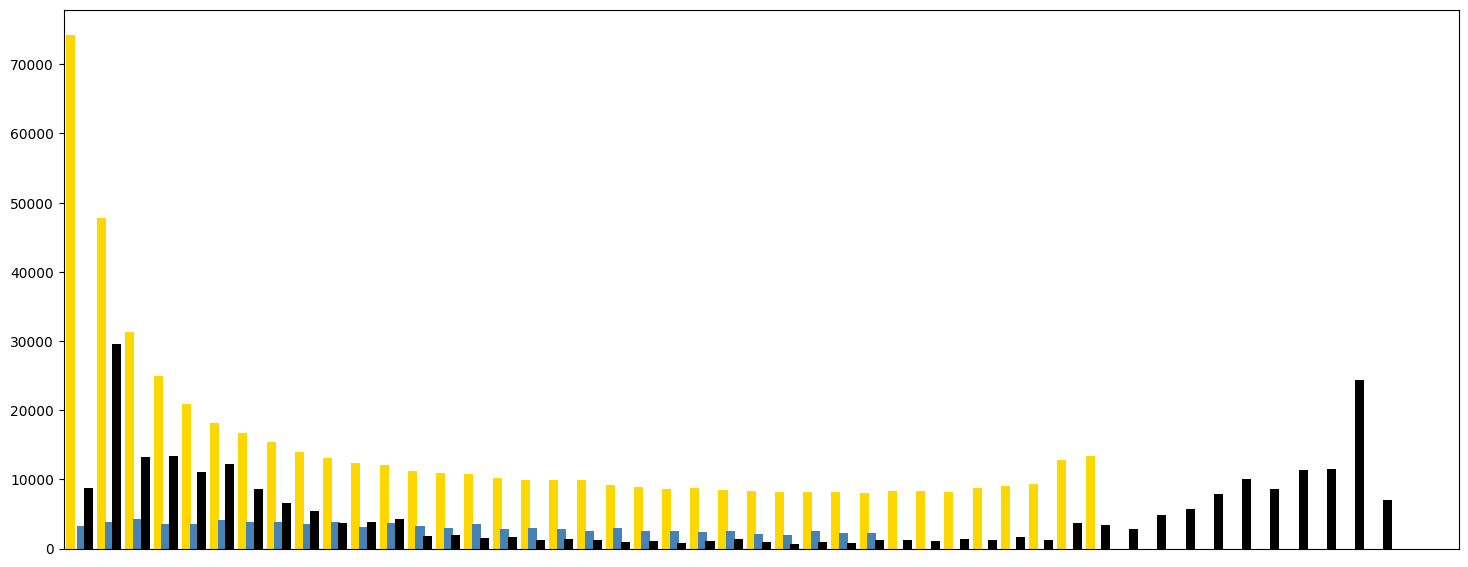

In [64]:
ausfs = pd.read_csv("angsd/sfs/AU_neutral_modified.sfs", sep='\t')
tisfs = pd.read_csv("angsd/sfs/TI_neutral_modified.sfs", sep='\t')
kisfs = pd.read_csv("angsd/sfs/KI_neutral_modified.sfs", sep='\t')

ausfs = ausfs.iloc[1:38]
tisfs = tisfs.iloc[1:30]
kisfs = kisfs.iloc[1:48]

bar_width = 0.32

x_ausfs = ausfs['Allele Count'] + 0.1
x_ausfs[1] = 1
x_tisfs = tisfs['Allele Count'] + bar_width + 0.05
x_kisfs = kisfs['Allele Count'] + 2 * bar_width

plt.figure(figsize=(18,7))
plt.bar(x_ausfs, ausfs['SFS Value'], width=bar_width, color='gold')
plt.bar(x_tisfs, tisfs['SFS Value'], width=bar_width, color='steelblue')
plt.bar(x_kisfs, kisfs['SFS Value'], width=bar_width, color='black')

plt.xlim(left=0.75)
plt.xticks([])

plt.savefig('plots/SFS_neutralSites.png', dpi=300, bbox_inches='tight')

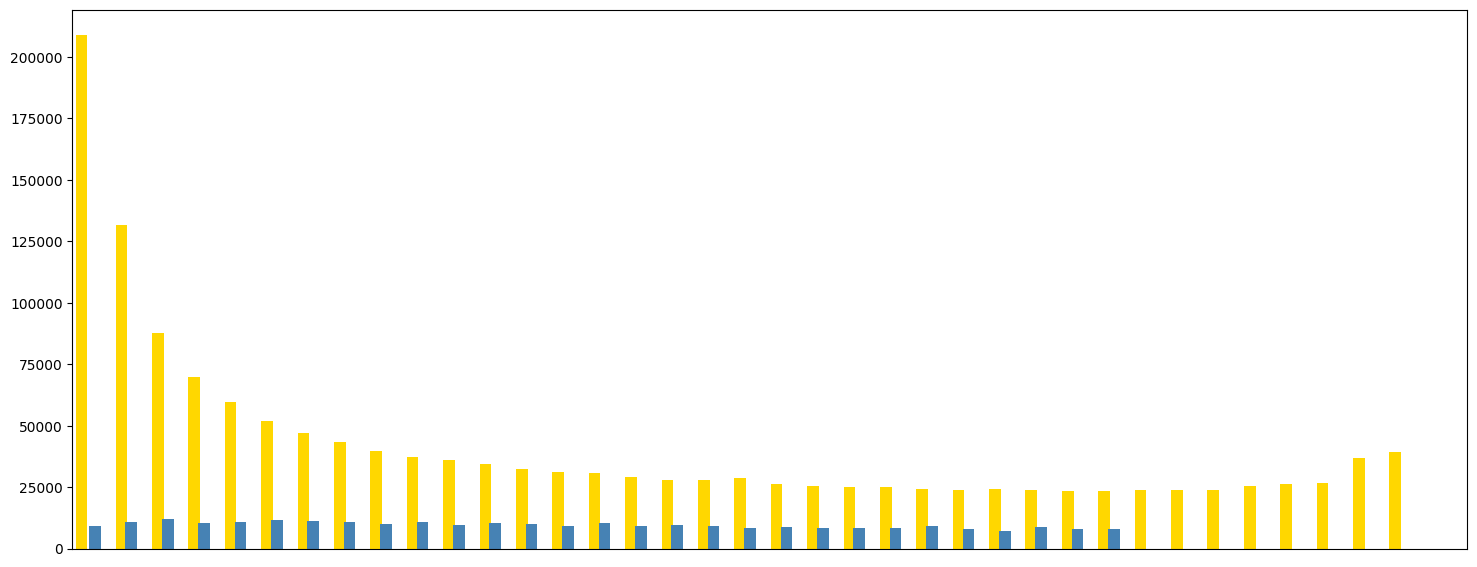

In [9]:
ausfs = pd.read_csv("angsd/sfs/AU_whole-genome_modified.sfs", sep='\t')
tisfs = pd.read_csv("angsd/sfs/TI_whole-genome_modified.sfs", sep='\t')
kisfs = pd.read_csv("angsd/sfs/KI_whole-genome_modified.sfs", sep='\t')

ausfs = ausfs.iloc[1:38]
tisfs = tisfs.iloc[1:30]
kisfs = kisfs.iloc[1:48]

bar_width = 0.32

x_ausfs = ausfs['Allele Count'] + 0.1
x_ausfs[1] = 1
x_tisfs = tisfs['Allele Count'] + bar_width + 0.05
x_kisfs = kisfs['Allele Count'] + 2 * bar_width

plt.figure(figsize=(18,7))

plt.bar(x_ausfs, ausfs['SFS Value'], width=bar_width, color='gold')
plt.bar(x_tisfs, tisfs['SFS Value'], width=bar_width, color='steelblue')
#plt.bar(x_kisfs, kisfs['SFS Value'], width=bar_width, color='black')

plt.xlim(left=0.75)
plt.xticks([])

plt.savefig('plots/SFS_whole-genome_Sites.png', dpi=300, bbox_inches='tight')

Folded SFS

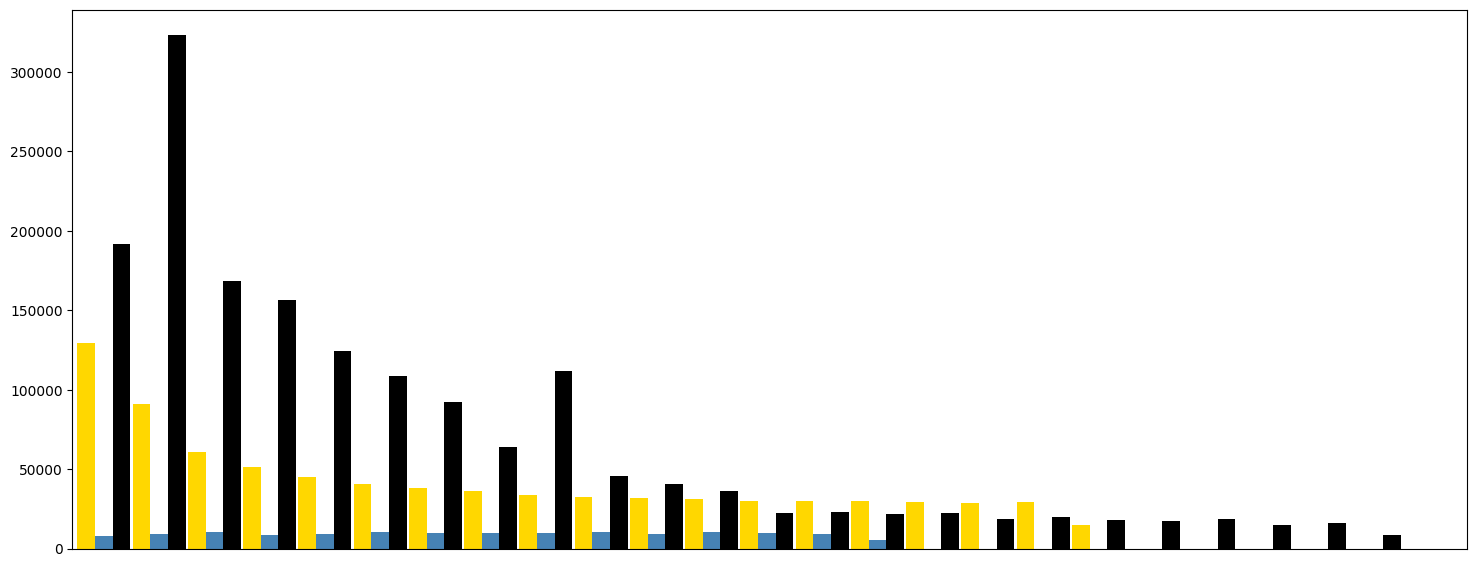

In [154]:
tisfs_fold = pd.read_csv("angsd/sfs/TI_neutral_modified_fold.sfs", sep='\t')
ausfs_fold = pd.read_csv("angsd/sfs/AU_neutral_modified_fold.sfs", sep='\t')
kisfs_fold = pd.read_csv("angsd/sfs/KI_neutral_modified_fold.sfs", sep='\t')

ausfs_fold = ausfs_fold.iloc[1:38]
tisfs_fold = tisfs_fold.iloc[1:30]
kisfs_fold = kisfs_fold.iloc[1:48]

bar_width = 0.32

x_ausfs_fold = ausfs_fold['Allele Count']
x_ausfs_fold[1] = 1
x_tisfs_fold = tisfs_fold['Allele Count'] + bar_width
x_kisfs_fold = kisfs_fold['Allele Count'] + 2 * bar_width

plt.figure(figsize=(18,7))

plt.bar(x_ausfs_fold, ausfs_fold['SFS Value'], width=bar_width, color='gold')
plt.bar(x_tisfs_fold, tisfs_fold['SFS Value'], width=bar_width, color='steelblue')
plt.bar(x_kisfs_fold, kisfs_fold['SFS Value'], width=bar_width, color='black')

plt.xlim(left=0.75)
plt.xticks([])

plt.savefig('plots/foldedSFS_neutral_Sites.png', dpi=300, bbox_inches='tight')

We also attempted to visualise the joint SFS. This wasn't particularly informative as the two populations were so differentiated. That is to say, alleles common in one population were rare or absent in another. As indicated by the high F<sub>ST</sub> plotted below.  

## SVs

C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\674116899.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auSVs['MAF Count'] = auSVs['MAF'] * 38
C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\674116899.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tiSVs['MAF Count'] = tiSVs['MAF'] * 30
C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\674116899.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

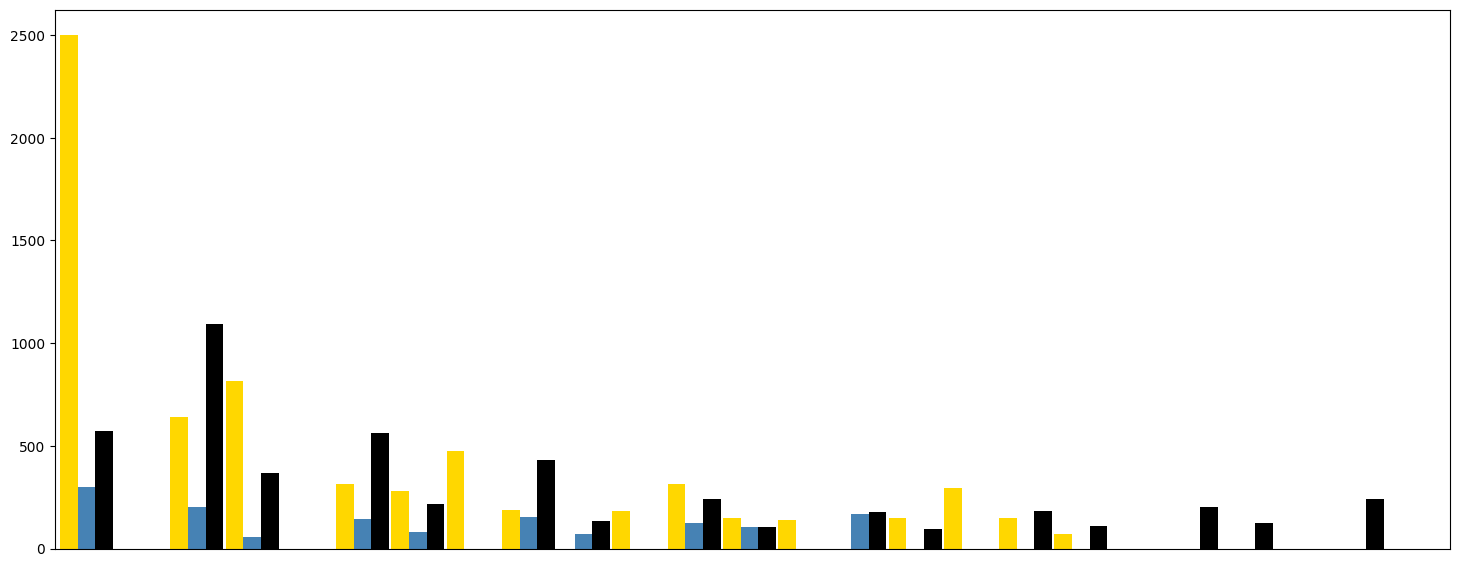

In [168]:
SVs = pd.read_csv('graphtyper/SV_characteristics.tsv', delimiter='\t')

aubins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
aulabels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
tibins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
tilabels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
kibins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
kilabels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

auSVs = SVs[SVs['Population']=='AU']
tiSVs = SVs[SVs['Population']=='TI']
kiSVs = SVs[SVs['Population']=='KI']

auSVs['MAF Count'] = auSVs['MAF'] * 38
tiSVs['MAF Count'] = tiSVs['MAF'] * 30
kiSVs['MAF Count'] = kiSVs['MAF'] * 48

auSVs['binned MAF'] = pd.cut(auSVs['MAF Count'], bins=aubins, labels=aulabels, include_lowest=True)
tiSVs['binned MAF'] = pd.cut(tiSVs['MAF Count'], bins=tibins, labels=tilabels, include_lowest=True)
kiSVs['binned MAF'] = pd.cut(kiSVs['MAF Count'], bins=kibins, labels=kilabels, include_lowest=True)

aucounts = auSVs.groupby('binned MAF').size().reset_index(name='count')
ticounts = tiSVs.groupby('binned MAF').size().reset_index(name='count')
kicounts = kiSVs.groupby('binned MAF').size().reset_index(name='count')

plt.figure(figsize=(18,7))

bar_width = 0.32

aucounts['binned MAF'] = aucounts['binned MAF'].astype(float)
ticounts['binned MAF'] = ticounts['binned MAF'].astype(float)
kicounts['binned MAF'] = kicounts['binned MAF'].astype(float)

x_aucounts = aucounts['binned MAF']
x_aucounts[1] = 1
x_ticounts = ticounts['binned MAF'] + bar_width
x_kicounts = kicounts['binned MAF'] + 2 * bar_width

plt.bar(x_aucounts, aucounts['count'], width=bar_width, color='gold')
plt.bar(x_ticounts, ticounts['count'], width=bar_width, color='steelblue')
plt.bar(x_kicounts, kicounts['count'], width=bar_width, color='black')

plt.xlim(left=0.75)
plt.xticks([])

plt.savefig('plots/SV_MAF.png', dpi=300, bbox_inches='tight')

In [155]:
SVs = pd.read_csv('graphtyper/SV_characteristics.tsv', delimiter='\t')

aubins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
aulabels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
tibins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
tilabels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
kibins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
kilabels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

auSVs = SVs[SVs['Population']=='AU']
tiSVs = SVs[SVs['Population']=='TI']
kiSVs = SVs[SVs['Population']=='KI']

auSVs['MAF Count'] = auSVs['MAF'] * 38
tiSVs['MAF Count'] = tiSVs['MAF'] * 30
kiSVs['MAF Count'] = kiSVs['MAF'] * 48

auSVs['binned MAF'] = pd.cut(auSVs['MAF Count'], bins=aubins, labels=aulabels, include_lowest=True)
tiSVs['binned MAF'] = pd.cut(tiSVs['MAF Count'], bins=tibins, labels=tilabels, include_lowest=True)
kiSVs['binned MAF'] = pd.cut(kiSVs['MAF Count'], bins=kibins, labels=kilabels, include_lowest=True)

aucounts = auSVs['binned MAF'].value_counts().sort_index()
ticounts = tiSVs['binned MAF'].value_counts().sort_index()
kicounts = kiSVs['binned MAF'].value_counts().sort_index()

print(aucounts)

binned MAF
1     2498
2      777
3      641
4      816
5        0
6      316
7      280
8      473
9      187
10       0
11     182
12     313
13     149
14     140
15       0
16     148
17     292
18     148
19      71
Name: count, dtype: int64


C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\1490085223.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auSVs['MAF Count'] = auSVs['MAF'] * 38
C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\1490085223.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tiSVs['MAF Count'] = tiSVs['MAF'] * 30
C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\1490085223.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True)

sns.countplot(data=auSVs, x='binned MAF', color='gold', ax=axes[0])
axes[0].set_title('Australian fairy tern')
sns.countplot(data=tiSVs, x='binned MAF', color='steelblue', ax=axes[1])
axes[1].set_title('Tara iti')
sns.countplot(data=kiSVs, x='binned MAF', color='black', ax=axes[2])
axes[2].set_title('Kakī')

for ax in axes:
    ax.set_xlabel('Minor Allele Count')
    ax.set_ylabel('Structural Variant Count')
plt.tight_layout(rect=[0, 0, 1, 0.96])

In [ ]:
ti_del = del_allele[del_allele['Population'] == 'TI']
tiLen = len(ti_del)

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

ti_del['binned'] = pd.cut(ti_del['Harmful Allele Frequency'], bins=bins, labels=labels, include_lowest=True)

grouped_ti_del = ti_del.groupby('binned').size().reset_index(name='count')
grouped_ti_del['Proportion'] = grouped_ti_del['count'] / tiLen

plt.figure(figsize=(10, 5))
sns.barplot(data=grouped_ti_del, x='binned', y='Proportion', color='steelblue')

plt.xlabel('Allele Frequency', fontsize=14)
plt.ylabel('Count Proportion', fontsize=14)

## Population Demography
### ROH length and estimates of recent N<sub>e</sub>
The below code and method was adapted from [Humble et al. (2023)](http://doi.org/10.1073/pnas.2210756120) to estimate recent trends in N<sub>e</sub> with runs of homozygosity (ROH). The original code from this paper is available [here](https://github.com/ehumble/SHO_roh_load_2022/tree/master).  

Using the formula summarised by Humble et al from [Thompson 2013](https://doi.org/10.1534/genetics.112.148825), we divided our ROHs into seven length classes (*L*) corresponding to <2, 2-4, 4-8, 8-16, 16-32, 32-64, and 64-128 generations (*g*) ago:
$$
L = \frac{100}{2 * g}
$$

Essentially, this equation is assuming that a time of depth of *g* should result in double the number omeioses events (*m*). Given that a linkage map was unavailable for their study species, Humble eta l assumed a recombination rate of 1 cM/Mb. However, recombination rate is heterogenous within and between avian lineages and even within and between chromosomes ([Nam et al. (2010)](https://doi.org/10.1186/gb-2010-11-6-r68)). To account for this, we also estimated N<sub>e</sub> using a mean recombination rate of 2 cM/Mb as a middle road of recombination rates observed in [Backström et al. (2010)](http://doi.org/10.1101/gr.101410.109) and [Smeds et al. (2016)](http://doi.org/10.1371/journal.pgen.1006044).
$$
L = \frac{100}{2(2 * g)}
$$

Using the lengths calculated fro each of these recobination rates, we estimated N<sub>e</sub> for each *g*. Here, *F<sub>ROH, t</sub>* represents average population inbreeding coefficient for the maximum numbers of generations (*t*) in the time periods corresponding for each of the seven size classes above.  
$$
F_{ROH, t} = 1 - (1 - \frac{1}{2 * N_{e}})^t
$$

We then define the function `inb_ne()` to estimate N<sub>e</sub> using the mean *F<sub>ROH</sub>* for each *L*.  
$$
N_{e} = \frac{1}{2 * (1 - f_{ROH})^\frac{1}{L}}
$$

Below we also define a function (`bootstrap_Ne()`) for bootstrapping with replacement for each N<sub>e</sub> estimate.

In [21]:
def inb_ne(mean_froh, class_):
    Ne = 1 / (2 * (1 - ((1 - mean_froh) ** (1 / class_))))
    return Ne

def bootstrap_Ne(iter, df, frac):
    sampled_df = (df
                  .groupby(['Generation Class', 'Population'], group_keys=False)
                  .apply(lambda x: x.sample(frac=frac, replace=True))
                  .groupby(['Generation Class', 'Population'], as_index=False)
                  .agg(mean_froh = ('fROH', 'mean'))
                  .assign(Ne = lambda x: inb_ne(x['mean_froh'], x['Generation Class']))
                  )
    return sampled_df

To estimate N<sub>e</sub> for each of the seven *L* defined above, we us the `ROHs.tsv` file. This time, we convert ROH sizes estimated by ROHAN to megabases (defined as `ROH Size in Mb` in the df below), assign the relevant Generation Class (*g*) for each *L* (defined as `length_class`) and find the *F<sub>ROH</sub>* for each ROH in each individual by dividing `ROH Size in Mb` by the estimated size of autosomal chromosomes for the tara iti and kakī reference genomes (in Mb).

In [22]:
roh = pd.read_csv('ROHAN_out/ROHs.tsv', delimiter='\t')
roh = roh[(roh['Sample']!='SP01') & (roh['Sample']!='TI22')]

roh['ROH Size in Mb'] = roh['ROH_size'] / 1000000

l_recomb = roh
h_recomb = roh

l_recomb['Generation Class'] = np.select(
    [
        l_recomb['ROH Size in Mb'] >= 25.0,
        (l_recomb['ROH Size in Mb'] < 25.0) & (l_recomb['ROH Size in Mb'] >= 12.5),
        (l_recomb['ROH Size in Mb'] < 12.5) & (l_recomb['ROH Size in Mb'] >= 6.25),
        (l_recomb['ROH Size in Mb'] < 6.25) & (l_recomb['ROH Size in Mb'] >= 3.125),
        (l_recomb['ROH Size in Mb'] < 3.125) & (l_recomb['ROH Size in Mb'] >= 1.5625),
        (l_recomb['ROH Size in Mb'] < 1.5625) & (l_recomb['ROH Size in Mb'] >= 0.78125),
        (l_recomb['ROH Size in Mb'] < 0.78125) & (l_recomb['ROH Size in Mb'] >= 0.390625),
    ],
    [2, 4, 8, 16, 32, 64, 128],
    default=np.nan
)

h_recomb['Generation Class'] = np.select(
    [
        h_recomb['ROH Size in Mb'] >= 12.5,
        (h_recomb['ROH Size in Mb'] < 12.5) & (h_recomb['ROH Size in Mb'] >= 6.25),
        (h_recomb['ROH Size in Mb'] < 6.25) & (h_recomb['ROH Size in Mb'] >= 3.125),
        (h_recomb['ROH Size in Mb'] < 3.125) & (h_recomb['ROH Size in Mb'] >= 1.5625),
        (h_recomb['ROH Size in Mb'] < 1.5625) & (h_recomb['ROH Size in Mb'] >= 0.78125),
        (h_recomb['ROH Size in Mb'] < 0.78125) & (h_recomb['ROH Size in Mb'] >= 0.390625),
        (h_recomb['ROH Size in Mb'] < 0.390625) & (h_recomb['ROH Size in Mb'] >= 0.1953125),
    ],
    [2, 4, 8, 16, 32, 64, 128],
    default=np.nan
)

l_recomb['length_class'] = l_recomb['Generation Class'].map({
    2: ">25.0",
    4: "12.5-25.0",
    8: "6.25-12.5",
    16: "3.12-6.25",
    32: "1.56-3.12",
    64: "0.78-1.56",
    128: "0.39-0.78"
})

h_recomb['length_class'] = h_recomb['Generation Class'].map({
    2: ">12.5",
    4: "6.25-12.5",
    8: "3.12-6.25",
    16: "1.56-3.12",
    32: "0.78-1.56",
    64: "0.39-0.78",
    128: "0.19-0.39"
})

fairy_lrecomb = l_recomb[(l_recomb['Population']!='KI') & (l_recomb['ROH Size in Mb']>=0.39)]
fairy_hrecomb = h_recomb[(h_recomb['Population']!='KI') & (h_recomb['ROH Size in Mb']>=0.19)]
kaki_lrecomb = l_recomb[(l_recomb['Population']=='KI') & (l_recomb['ROH Size in Mb']>=0.39)]
kaki_hrecomb = h_recomb[(h_recomb['Population']=='KI') & (h_recomb['ROH Size in Mb']>=0.19)]

fairy_low = (fairy_lrecomb
    .groupby(['Sample', 'Population', 'Generation Class', 'length_class'], as_index=False, dropna=False)
    .agg(fROH=('ROH Size in Mb', lambda x: sum((x / 1088.797119))))
    )
fairy_high = (fairy_hrecomb
    .groupby(['Sample', 'Population', 'Generation Class', 'length_class'], as_index=False, dropna=False)
    .agg(fROH=('ROH Size in Mb', lambda x: sum((x / 1088.797119))))
    )
kaki_low = (kaki_lrecomb
    .groupby(['Sample', 'Population', 'Generation Class', 'length_class'], as_index=False, dropna=False)
    .agg(fROH=('ROH Size in Mb', lambda x: sum((x / 1095.624494))))
    )
kaki_high = (kaki_hrecomb
    .groupby(['Sample', 'Population', 'Generation Class', 'length_class'], as_index=False, dropna=False)
    .agg(fROH=('ROH Size in Mb', lambda x: sum((x / 1095.624494))))
    )

kaki_high.head()

,Sample,Population,Generation Class,length_class,fROH
0,H01383,KI,4.0,6.25-12.5,0.006070
1,H01383,KI,8.0,3.12-6.25,0.010359
2,H01383,KI,16.0,1.56-3.12,0.018118
3,H01383,KI,32.0,0.78-1.56,0.026788
4,H01383,KI,64.0,0.39-0.78,0.031398


In [ ]:
iterations = 100
lowkiresults = [bootstrap_Ne(i, kaki_low, 0.5) for i in range(iterations)]
highkiresults = [bootstrap_Ne(i, kaki_high, 0.5) for i in range(iterations)]
lowftresults = [bootstrap_Ne(i, fairy_low, 0.5) for i in range(iterations)]
highftresults = [bootstrap_Ne(i, fairy_high, 0.5) for i in range(iterations)]

lowkiuncert = (pd.concat(lowkiresults, keys=range(iterations), names=['iter'])
                .reset_index(level='iter'))
highkiuncert = (pd.concat(highkiresults, keys=range(iterations), names=['iter'])
                .reset_index(level='iter'))
lowftuncert = (pd.concat(lowftresults, keys=range(iterations), names=['iter'])
                .reset_index(level='iter'))
highftuncert = (pd.concat(highftresults, keys=range(iterations), names=['iter'])
                .reset_index(level='iter'))

uncertainty_low = pd.concat([lowftuncert, lowkiuncert], axis=0, ignore_index=True)
uncertainty_high = pd.concat([highftuncert, highkiuncert], axis=0, ignore_index=True)

In [63]:
print(uncertainty_high.groupby(['Generation Class', 'Population'])['Ne'].mean())

Generation Class  Population
2.0               TI              14.290875
4.0               TI              16.879177
8.0               AU             834.661003
                  KI             791.487648
                  TI              43.388653
16.0              AU            1911.444266
                  KI             677.818761
                  TI             104.494564
32.0              AU            2032.710574
                  KI             732.334644
                  TI             281.486209
64.0              AU            2528.208427
                  KI             848.979808
                  TI             530.734949
128.0             AU            3574.944224
                  KI            1594.802812
                  TI            1342.987991
Name: Ne, dtype: float64


C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\1727459027.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['<2', '2-4', '4-8', '8-16', '16-32', '32-64', '64-128'])


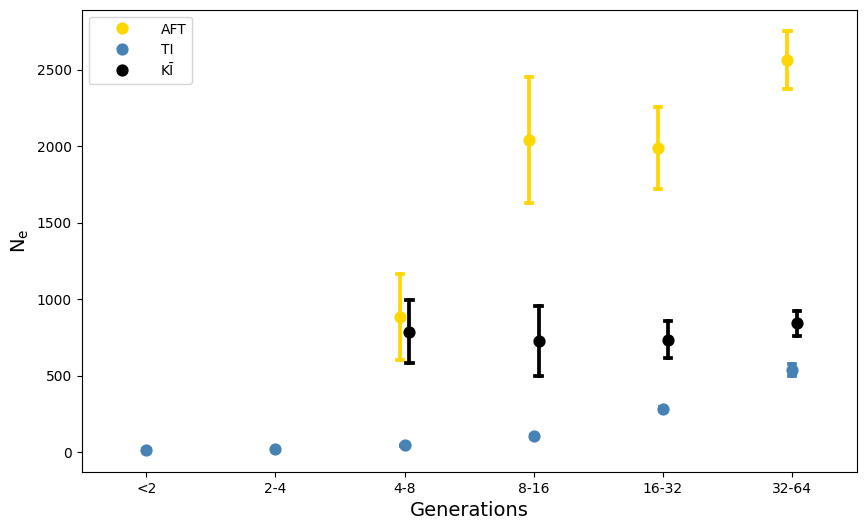

In [24]:
palette = ['gold', 'steelblue', 'black']
plt.figure(figsize=(10, 6))
ax = sns.pointplot(data=uncertainty_low, x='Generation Class', y='Ne', dodge=True, hue='Population', hue_order=['AU', 'TI', 'KI'],
                palette=palette, errorbar='sd', capsize=0.05, n_boot=100, estimator='mean', markers='o', linestyles='none')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles,
        labels=['AFT', 'TI', 'KĪ'],
        loc='upper left', handlelength=4,
        handler_map={tuple: HandlerTuple(ndivide=None)})

params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
ax.set_xticklabels(['<2', '2-4', '4-8', '8-16', '16-32', '32-64', '64-128'])
ax.set_xlabel('Generations', fontsize=14)
ax.set_ylabel('$N_{e}$', fontsize=14)

plt.savefig('plots/ROH_lowRecomb_Ne_esimtates.png', dpi=300, bbox_inches='tight')

C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\3920195757.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['<2', '2-4', '4-8', '8-16', '16-32', '32-64', '64-128'])


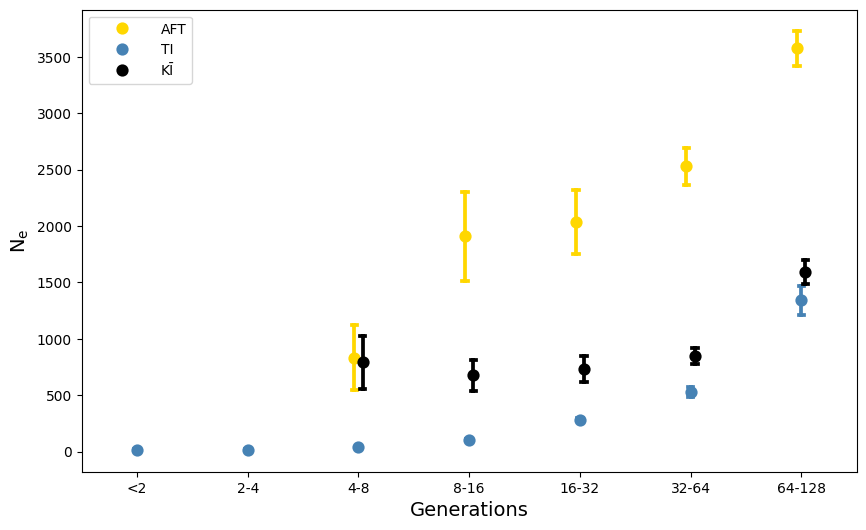

In [27]:
palette = ['gold', 'steelblue', 'black']
plt.figure(figsize=(10, 6))
ax = sns.pointplot(data=uncertainty_high, x='Generation Class', y='Ne', dodge=True, hue='Population', hue_order=['AU', 'TI', 'KI'],
                palette=palette, errorbar='sd', capsize=0.05, n_boot=100, estimator='mean', markers='o', linestyles='none')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles,
        labels=['AFT', 'TI', 'KĪ'],
        loc='upper left', handlelength=4,
        handler_map={tuple: HandlerTuple(ndivide=None)})

params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)
ax.set_xticklabels(['<2', '2-4', '4-8', '8-16', '16-32', '32-64', '64-128'])
ax.set_xlabel('Generations', fontsize=14)
ax.set_ylabel('$N_{e}$', fontsize=14)

plt.savefig('plots/ROH_highRecomb_Ne_esimtates.png', dpi=300, bbox_inches='tight')

### StairwayPlot2
Below script was modified from [here](https://github.com/xiaoming-liu/stairway-plot-v2/issues/2).

In [ ]:
au_stairway = pd.read_csv('stairwayplot2/AU_neutral_temp/Australian fairy tern (neutral).final.summary', delimiter='\t')
ti_stairway = pd.read_csv('stairwayplot2/TI_neutral_temp/Tara iti (neutral).final.summary', delimiter='\t')
#ki_stariway = pd.read_csv('stairwayplot2/KI_neutral_temp/Kakī (neutral).final.summary', delimiter='\t')

plt.figure (figsize=(15, 5))

plt.xscale('log')
plt.yscale('log')
plt.xlim(0, 100)
plt.ylim(0, 1000)

x_ticks = [10**0, 10**1, 10**2]
x_labels = ['100', '1,000', '10,000']
y_ticks = [10**0, 10**1, 10**2, 10**3]
y_labels = ['1000', '1,000', '10,000', '100,000']


plt.step(au_stairway['year'] / 100, au_stairway['Ne_median'] / 100, where='post', color = 'gold', linewidth=2, label='Australia')
plt.step(au_stairway['year'] / 100, au_stairway['Ne_2.5%'] / 100, where='post', color = 'gold', linewidth='dashed')
plt.step(au_stairway['year'] / 100, au_stairway['Ne_97.5%'] / 100, where='post', color = 'gold', linewidth='dashed')

plt.step(ti_stairway['year'] / 100, ti_stairway['Ne_median'] / 100, where='post', color = 'steelblue', linewidth=2, label='Tara iti')
plt.step(ti_stairway['year'] / 100, ti_stairway['Ne_2.5%'] / 100, where='post', color = 'steelblue', linewidth='dashed')
plt.step(ti_stairway['year'] / 100, ti_stairway['Ne_97.5%'] / 100, where='post', color = 'steelblue', linewidth='dashed')

plt.legend(loc='upper right')
plt.xlabel('Years Before Present', fontsize=14)
plt.ylabel('Effective Population Size', fontsize=14)

plt.savefig('plots/fairy_Ne_plot.png', dpi=300, bbox_inches='tight')

## Population Structure
### SNP-based Estimates of F<sub>ST</sub>
Plot of F<sub>ST</sub> between putatively neutral sites between Australian fairy tern and tara iti.  

C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\2298785328.py:7: UserWarning: 
The palette list has fewer values (2) than needed (22) and will cycle, which may produce an uninterpretable plot.
  ax=sns.scatterplot(data=fst, x='x', y='FST', hue='chr', palette=palette, alpha=0.5, s=3, legend=False)


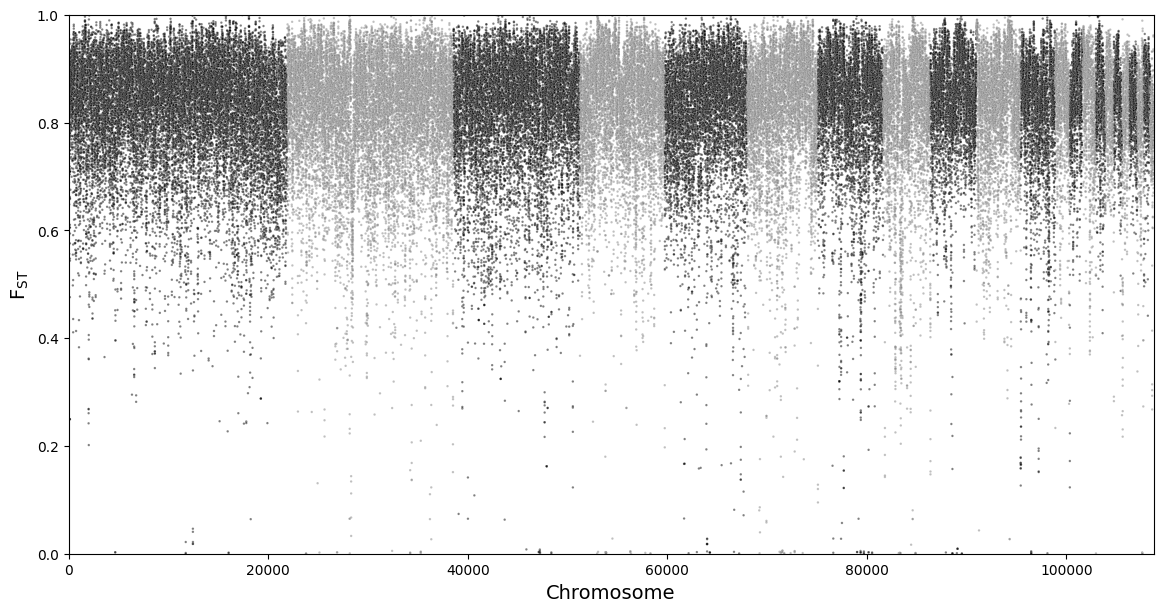

In [61]:
fst = pd.read_csv('angsd/distance/GLOBAL_whole-genome_stat2_50KBwindow_10KBstep.tsv', sep='\t', usecols=['chr', 'midPos', 'Nsites', 'FST'])

fst['x'] = range(len(fst))

plt.figure(figsize=(14,7))
palette=['black', 'grey']
ax=sns.scatterplot(data=fst, x='x', y='FST', hue='chr', palette=palette, alpha=0.5, s=3, legend=False)

ax.set_xlabel('Chromosome', fontsize=14)
ax.set_ylabel('$F_{ST}$', fontsize=14)
ax.set_xlim(0, 108730)
ax.set_ylim(0, 1)

plt.savefig('plots/whole-genome_Fst_allChr.png')

C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\1709392401.py:7: UserWarning: 
The palette list has fewer values (2) than needed (22) and will cycle, which may produce an uninterpretable plot.
  ax=sns.scatterplot(data=neutralfst, x='x', y='FST', hue='chr', palette=palette, alpha=0.5, s=3, legend=False)


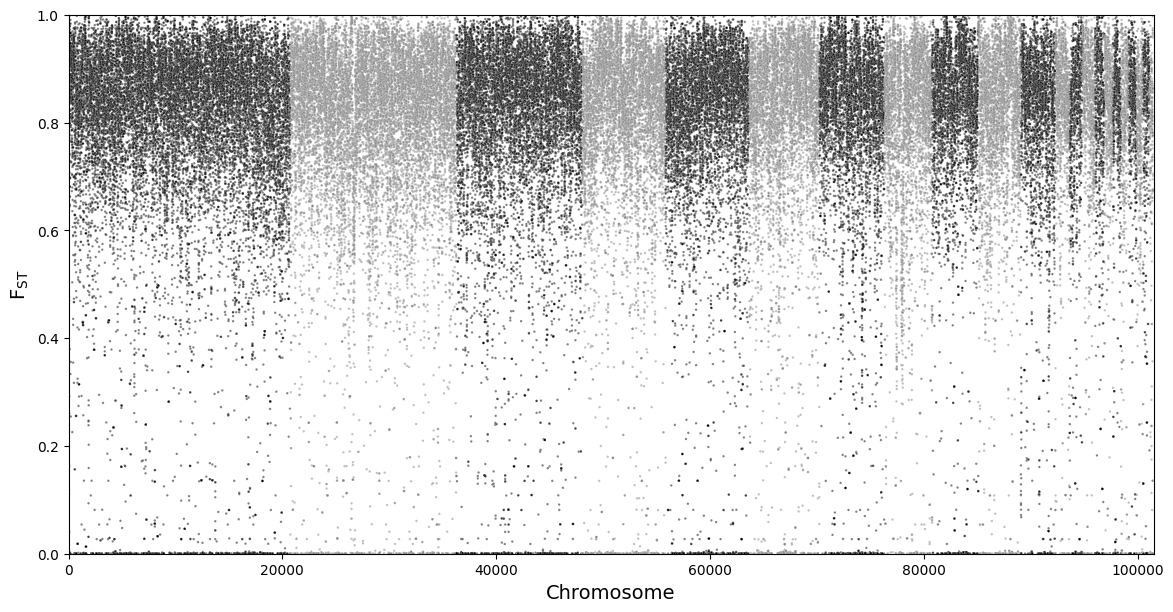

In [60]:
neutralfst = pd.read_csv('angsd/distance/GLOBAL_neutral_stat2_50KBwindow_10KBstep.tsv', sep='\t', usecols=['chr', 'midPos', 'Nsites', 'FST'])

neutralfst['x'] = range(len(neutralfst))

plt.figure(figsize=(14,7))
palette=['black', 'grey']
ax=sns.scatterplot(data=neutralfst, x='x', y='FST', hue='chr', palette=palette, alpha=0.5, s=3, legend=False)

ax.set_xlabel('Chromosome', fontsize=14)
ax.set_ylabel('$F_{ST}$', fontsize=14)
ax.set_xlim(0, 101500)
ax.set_ylim(0, 1)

plt.savefig('plots/neutral_Fst_allChr.png')

C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\1265829523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr1fst['x'] = range(len(chr1fst))


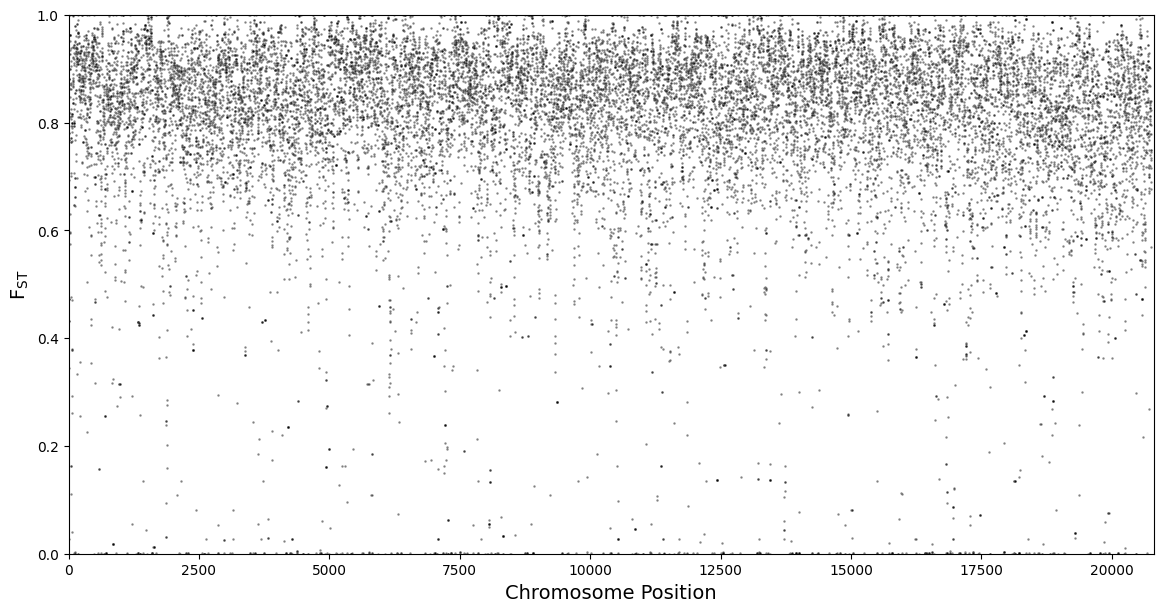

In [62]:
chr1fst = neutralfst[(neutralfst['chr']=='CM020437.1_RagTag')]

chr1fst['x'] = range(len(chr1fst))

plt.figure(figsize=(14,7))
palette=['black', 'grey']
ax=sns.scatterplot(data=chr1fst, x='x', y='FST', color='black', alpha=0.5, s=3, legend=False)

ax.set_xlabel('Chromosome Position', fontsize=14)
ax.set_ylabel('$F_{ST}$', fontsize=14)
ax.set_xlim(0, 20800)
ax.set_ylim(0, 1)

plt.savefig('plots/neutral_Fst_Chr1.png')

### Multiple Dimensional Scaling (MDS)
#### SNP-based Inference of Structure
The high F<sub>ST</sub> inferred from SNP data corresponds to high differentiation observed in our MDS with over 97% of population variance represented along one dimension.  

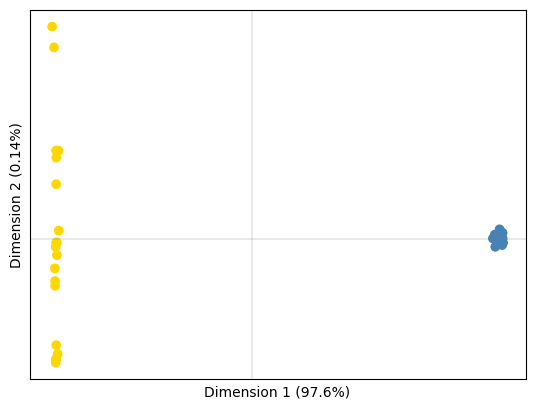

In [62]:
mds = pd.read_csv('angsd/structure_MDS/GLOBAL_neutral.mds', sep='\t')
pops = pd.read_csv('angsd/structure_MDS/mds_pops.tsv', sep='\t', header=None)

color = ['gold'] * 19 + ['steelblue'] * 15

plt.scatter(mds['D1_97.5736950999342'], mds['D2_0.142602294031928'], c=color)
plt.axvline(x=sum(mds['D1_97.5736950999342']) / len(mds['D1_97.5736950999342']), color='grey', linewidth=0.25)
plt.axhline(y=sum(mds['D2_0.142602294031928']) / len(mds['D2_0.142602294031928']), color='grey', linewidth=0.25)
plt.xticks([])
plt.yticks([])
plt.xlabel('Dimension 1 (97.6%)')
plt.ylabel('Dimension 2 (0.14%)')
plt.savefig('plots/GLOBAL_neutral_MDS.png', dpi=300, bbox_inches='tight')

#### SV-based inference of structure
Taking our genotyped and curated variants, we first examined population structure using all SVs in a MDS.

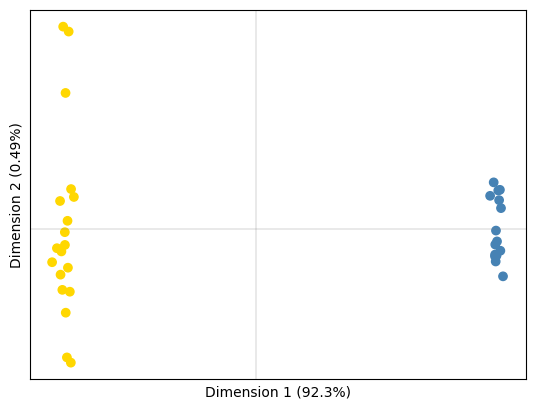

In [14]:
mds = pd.read_csv('graphtyper/fairy_mds/GLOBAL_sv.mds', sep='\t')

color = ['gold'] * 19 + ['steelblue'] * 15

plt.scatter(mds['D1_92.2527381611509'], mds['D2_0.490799765875673'], c=color)
plt.axvline(x=sum(mds['D1_92.2527381611509']) / len(mds['D1_92.2527381611509']), color='grey', linewidth=0.25)
plt.axhline(y=sum(mds['D2_0.490799765875673']) / len(mds['D2_0.490799765875673']), color='grey', linewidth=0.25)
plt.xticks([])
plt.yticks([])
plt.xlabel('Dimension 1 (92.3%)')
plt.ylabel('Dimension 2 (0.49%)')

plt.savefig('plots/GLOBAL_SV_MDS.png', dpi=300, bbox_inches='tight')

## Summary Statistics
### Tajima's D
Here we  plot Tajima's D estimates for Australian fairy tern and tara iti.  

In [ ]:
auTajima = au_neutral[['Chr', 'WinCenter', 'Tajima', 'nSites']]
tiTajima = ti_neutral[['Chr', 'WinCenter', 'Tajima', 'nSites']]

auTajima['x'] = range(len(auTajima))
tiTajima['x'] = range(len(tiTajima))

plt.figure(figsize=(14,7))
ax = sns.scatterplot(data=auTajima, x='x', y='Tajima', hue='Chr', palette=aupalette, alpha=0.5, s=3, legend=False)
sns.scatterplot(data=tiTajima, x='x', y='Tajima', hue='Chr', palette=nzpalette, alpha=0.5, s=3, legend=False)

ax.set_xlabel('Chromosome Position', fontsize=14)
ax.set_ylabel("Tajima's D", fontsize=14)

#plt.savefig('data/plots/AU_Tajima_neutralSites.png')
#plt.savefig('data/plots/TI_Tajima_neutralSites.png')
plt.savefig('plots/GLOBAL_Tajima_neutralSites.png')

## Load Estimates
### Harmful allele frequency
BEWARE THIS ALL NEEDS TO BE REDONE AND INSN'T HOW IT'LL BE FOR THE MANUSCRIPT

In [ ]:
del_allele = pd.read_csv('SIFT/sift_del_allele_frequency.tsv', delimiter='\t')

ti_del = del_allele[del_allele['Population'] == 'TI']
tiLen = len(ti_del)

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

ti_del['binned'] = pd.cut(ti_del['Harmful Allele Frequency'], bins=bins, labels=labels, include_lowest=True)

grouped_ti_del = ti_del.groupby('binned').size().reset_index(name='count')
grouped_ti_del['Proportion'] = grouped_ti_del['count'] / tiLen

plt.figure(figsize=(10, 5))
sns.barplot(data=grouped_ti_del, x='binned', y='Proportion', color='steelblue')

plt.xlabel('Allele Frequency', fontsize=14)
plt.ylabel('Count Proportion', fontsize=14)

plt.savefig('plots/TI_harmful_allele.png', dpi=300, bbox_inches='tight')

In [ ]:
au_del = del_allele[del_allele['Population'] == 'AU']
auLen = len(au_del)

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

au_del['binned'] = pd.cut(au_del['Harmful Allele Frequency'], bins=bins, labels=labels, include_lowest=True)

grouped_au_del = au_del.groupby('binned').size().reset_index(name='count')
grouped_au_del['Proportion'] = grouped_au_del['count'] / auLen

plt.figure(figsize=(10, 5))
sns.barplot(data=grouped_au_del, x='binned', y='Proportion', color='gold')

plt.xlabel('Allele Frequency', fontsize=14)
plt.ylabel('Count Proportion', fontsize=14)
plt.ylim(0, 0.7)

plt.savefig('plots/AU_harmful_allele.png', dpi=300, bbox_inches='tight')

In [ ]:
au_ulowFreq = len(au_del[au_del['Harmful Allele Frequency']<=0.1])
ti_ulowFreq = len(ti_del[ti_del['Harmful Allele Frequency']<=0.1])
au_highFreq = len(au_del[au_del['Harmful Allele Frequency']>=0.5])
ti_highFreq = len(ti_del[ti_del['Harmful Allele Frequency']>=0.5])

au_ulowFreq_proportion = au_ulowFreq / 348
ti_ulowFreq_proportion = ti_ulowFreq / 104

au_highFreq_proportion = au_highFreq / 348
ti_highFreq_proportion = ti_highFreq / 104

print('The proportion of deleterious variants with a allele frequency <= 0.1 is ', ti_ulowFreq_proportion, ' for TI and ', au_ulowFreq_proportion, ' for AU.')
print('Proportion of harmful alleles with frequency >=0.5 is ', ti_highFreq_proportion, ' and ', au_highFreq_proportion, ' for tara iti and AFT respectively.')

# Structural Variants
## Structural Variant Characteristics
Here we examine the number of SVs by type found within the fairy tern species complex and the critically endangered kakī.  

C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\2357229104.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Deletions', 'Duplications', 'Insertions'], rotation=45)
C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\2357229104.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Deletions', 'Duplications', 'Insertions'], rotation=45)
C:\Users\Jana\AppData\Local\Temp\ipykernel_17952\2357229104.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Deletions', 'Duplications', 'Insertions'], rotation=45)


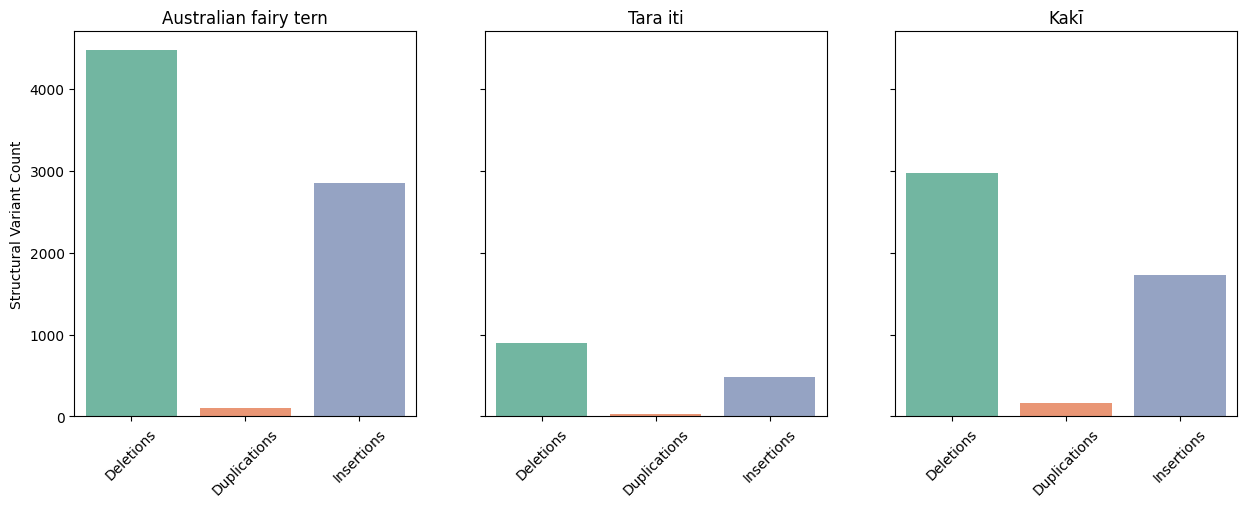

In [102]:
SVs = pd.read_csv('graphtyper/SV_characteristics.tsv', delimiter='\t')
auSVs = SVs[SVs['Population']=='AU']
tiSVs = SVs[SVs['Population']=='TI']
kiSVs = SVs[SVs['Population']=='KI']

palette = {
    'DEL': '#66c2a5',
    'DUP': '#fc8d62',
    'INS': '#8da0cb'
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

sns.countplot(data=auSVs, x='SV Type', hue='SV Type', order=['DEL', 'DUP', 'INS'], palette=palette, ax=axes[0])
axes[0].set_title('Australian fairy tern')
sns.countplot(data=tiSVs, x='SV Type', hue='SV Type', order=['DEL', 'DUP', 'INS'], palette=palette, ax=axes[1])
axes[1].set_title('Tara iti')
sns.countplot(data=kiSVs, x='SV Type', hue='SV Type', order=['DEL', 'DUP', 'INS'], palette=palette, ax=axes[2])
axes[2].set_title('Kakī')

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('Structural Variant Count')
    ax.set_xticklabels(['Deletions', 'Duplications', 'Insertions'], rotation=45)

plt.savefig('plots/SV_counts.png', dpi=300, bbox_inches='tight')

Counts per chromosome

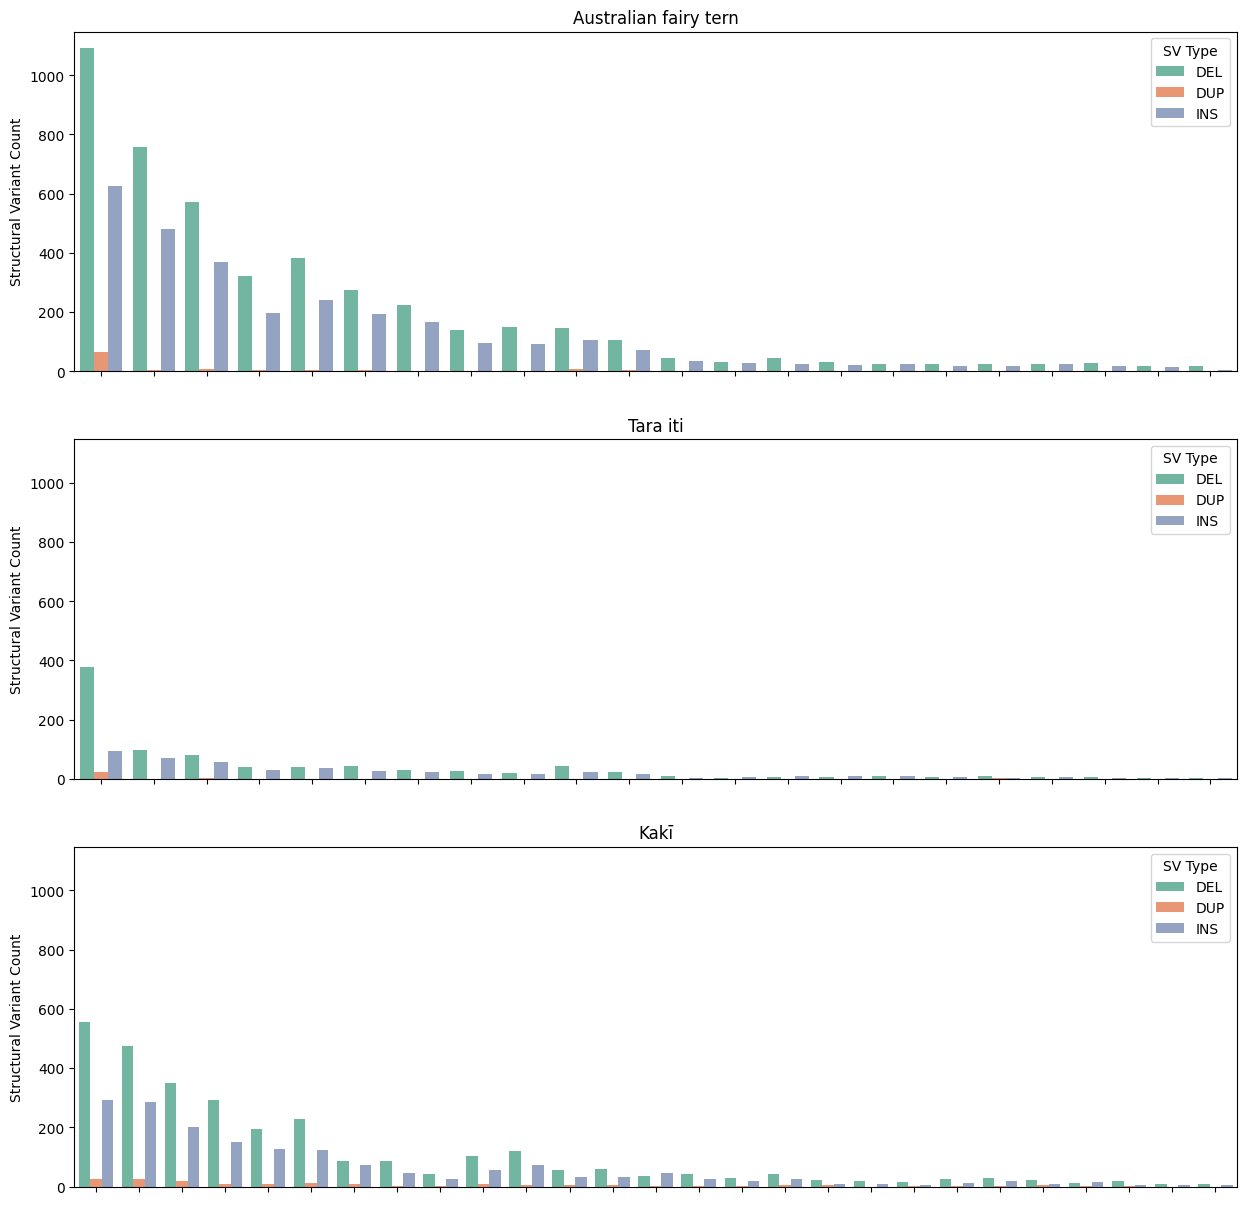

In [110]:
SVs = pd.read_csv('graphtyper/SV_characteristics.tsv', delimiter='\t')
auSVs = SVs[SVs['Population']=='AU']
tiSVs = SVs[SVs['Population']=='TI']
kiSVs = SVs[SVs['Population']=='KI']

palette = {
    'DEL': '#66c2a5',
    'DUP': '#fc8d62',
    'INS': '#8da0cb'
}

fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=False, sharey=True)

sns.countplot(data=auSVs, x='Chromosome', hue='SV Type', hue_order=['DEL', 'DUP', 'INS'], palette=palette, ax=axes[0])
axes[0].set_title('Australian fairy tern')
sns.countplot(data=tiSVs, x='Chromosome', hue='SV Type', hue_order=['DEL', 'DUP', 'INS'], palette=palette, ax=axes[1])
axes[1].set_title('Tara iti')
sns.countplot(data=kiSVs, x='Chromosome', hue='SV Type', hue_order=['DEL', 'DUP', 'INS'], palette=palette, ax=axes[2])
axes[2].set_title('Kakī')

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('Structural Variant Count')
    ax.set_xticklabels('')

plt.savefig('plots/SV_chr_counts.png', dpi=300, bbox_inches='tight')

SV Length Distributions

In [ ]:
SVs = pd.read_csv('graphtyper/SV_characteristics.tsv', delimiter='\t')
auSVs = SVs[SVs['Population']=='AU']
tiSVs = SVs[SVs['Population']=='TI']
kiSVs = SVs[SVs['Population']=='KI']

palette = {
    'DEL': '#66c2a5',
    'DUP': '#fc8d62',
    'INS': '#8da0cb'
}

fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=False, sharey=True)

sns.countplot(data=auSVs, x='Chromosome', hue='SV Type', hue_order=['DEL', 'DUP', 'INS'], palette=palette, ax=axes[0])
axes[0].set_title('Australian fairy tern')
sns.countplot(data=tiSVs, x='Chromosome', hue='SV Type', hue_order=['DEL', 'DUP', 'INS'], palette=palette, ax=axes[1])
axes[1].set_title('Tara iti')
sns.countplot(data=kiSVs, x='Chromosome', hue='SV Type', hue_order=['DEL', 'DUP', 'INS'], palette=palette, ax=axes[2])
axes[2].set_title('Kakī')

for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('Structural Variant Count')
    ax.set_xticklabels('')

plt.savefig('plots/SV_chr_counts.png', dpi=300, bbox_inches='tight')